In [1]:
### Notebook for P3D stuff!

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

jax version 0.4.26
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [3]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  320#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [4]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_38895/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-20 21:35:21.646823: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(128, 128, 65)


In [5]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = jnp.sqrt((kz/(k**2+0.00001)))


In [6]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

#loading in fiducial model
m_array = np.load("pkell_red.npy")
m_array = jnp.array(m_array[np.where(m_array[:,1]<6)])
kmax = m_array[-1,0]
print(m_array.shape,kmax)


(189, 3) 3.1252677


In [7]:
import jaxinterp2d

k_in = (k.flatten()/kmax*62)

l0 = np.where(m_array[:,1]==0)[0]
k_l0 = m_array[l0,0]
Pk_l0 = m_array[l0,2]
func1 = map_coordinates(Pk_l0,np.array([k_in]),mode="nearest",order=1)
func1 = func1.reshape(128,128,65)

l2 = np.where(m_array[:,1]==2)[0]
k_l2 = m_array[l2,0]
Pk_l2 = m_array[l2,2]
func2 = map_coordinates(Pk_l2,np.array([k_in]),mode="nearest",order=1)
func2 = func2.reshape(128,128,65)

l4 = np.where(m_array[:,1]==4)[0]
k_l4 = m_array[l4,0]
Pk_l4 = m_array[l4,2]
func4 = map_coordinates(Pk_l4,np.array([k_in]),mode="nearest",order=1)
func4 = func4.reshape(128,128,65)



In [8]:
k_ind_optim_max = 40
ell_bins=3
k_bins=63
tff = m_array[:,2].reshape(ell_bins,k_bins)
theta_fid = m_array[:,2].reshape(ell_bins,k_bins)[:,:k_ind_optim_max]

from scipy.special import legendre

def power_b(theta,tff=tff):    
    tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(ell_bins,k_ind_optim_max))
    func1 = map_coordinates(tff[0], np.array([k_in]), mode="nearest", order=1)
    func1 = func1.reshape(128,128,65)
    func2 = map_coordinates(tff[1], np.array([k_in]), mode="nearest", order=1)
    func2 = func2.reshape(128,128,65)
    func4 = map_coordinates(tff[2], np.array([k_in]), mode="nearest", order=1)
    func4 = func4.reshape(128,128,65)
    func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu))
    return func/15


In [9]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [10]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [11]:
tf_cut_flat = theta_fid.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [12]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [13]:
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(tf_cut_flat)
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

np.save("example_gen_field",lin_modes_real)

In [14]:
rng = jax.random.PRNGKey(1)

In [15]:
x_data = x

In [16]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.2#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 200
nsims= 10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [17]:
print(x_data)

[ 0.07581939  0.11979607  0.11671767 ... -0.0077379   0.00956282
  0.01695987]


In [18]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.7
[[-3.3490709e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.1450018e-05  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.9234273e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2977884e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.4834088e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.0766504e-06]]
[ 0.41000003  0.41000006  0.41000006  0.07014257 -0.00999994 -0.00999992
 -0.00999998 -0.00999998 -0.00999996 -0.00999994 -0.01       -0.01
 -0.00999995 -0.0099999  -0.00999992  0.41000012  0.41000012  0.41
  0.41000006  0.41000006  0.41000006  0.41000006  0.4100001   0.4100001
  0.41000018  0.41000012  0.41000003  0.41000003  0.4100001   0.4100001
  0.41000015  0.41000006  0.41000006 

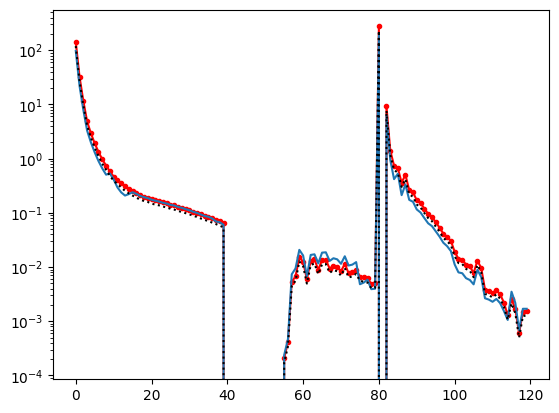

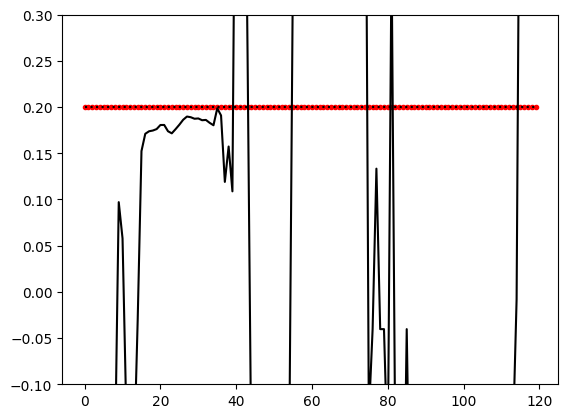

step: 4 0.6649999999999999
[[-2.8265957e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4769043e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.9914113e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6072616e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4981447e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6913560e-05]]
[ 0.65731245  0.5491024   0.46335694  0.10757564 -0.28419685 -0.3120653
 -0.05106149 -0.04490086 -0.04430696 -0.04200263 -0.04382897 -0.04479793
 -0.04555193 -0.04515539 -0.03159434  0.15097696  0.13958515  0.37951002
  0.40216434  0.36478359  0.30865648  0.13958514  0.2777994   0.23617657
  0.316454    0.36609614  0.377234    0.38222182  0.3830268   0.38072947
  0.37901

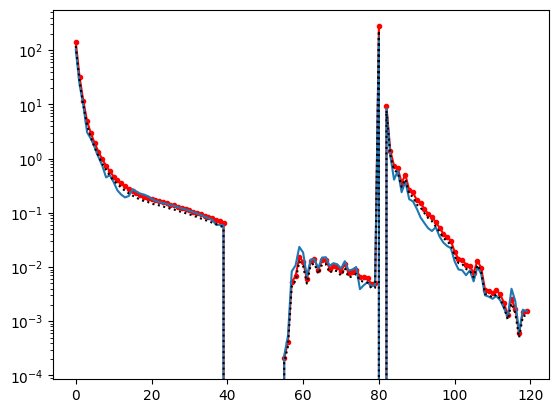

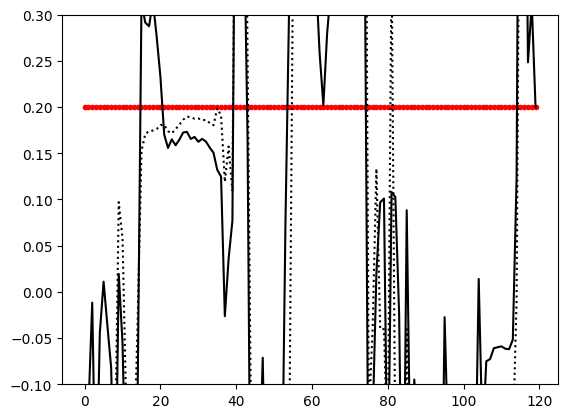

step: 7 0.6317499999999999
[[-2.9746344e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0606777e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3255492e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2781982e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3861446e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.5587641e-05]]
[ 0.6579695   0.38567474  0.42060712  0.15106435 -0.32636526 -0.3262447
 -0.23056136 -0.06588322 -0.40533817 -0.43923566 -0.31809852 -0.14857371
 -0.36779967 -0.09452826  0.37817955  0.17197002  0.30519214  0.57998323
  0.70093733  0.67241067  0.4988332   0.13280211  0.06019743  0.01216738
  0.07789763  0.19383956  0.25404856  0.21450044  0.4171397   0.41620457
  0.29111

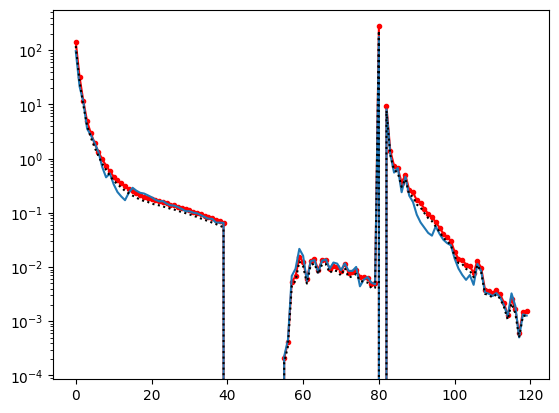

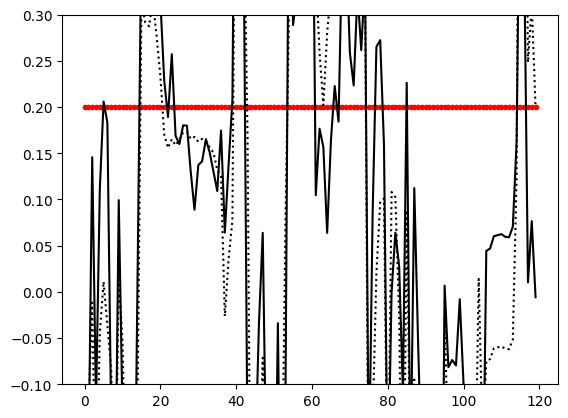

step: 10 0.6001624999999999
[[-7.4461877e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.1085816e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.4362179e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.3747246e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.2366225e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8284283e-05]]
[ 0.715413    0.59015423  0.3611071  -0.17825466 -0.13146189 -0.11280645
 -0.08835413  0.06681959 -0.26464078 -0.48280862 -0.4348688  -0.17882112
 -0.41197795 -0.21436252  0.3017663   0.20640858  0.3162352   0.77172
  0.9073523   0.9633093   0.7819178   0.27027187  0.1506598  -0.01685152
 -0.09584966 -0.01059616  0.06660888  0.00652665  0.39489967  0.5880664
  0.2681810

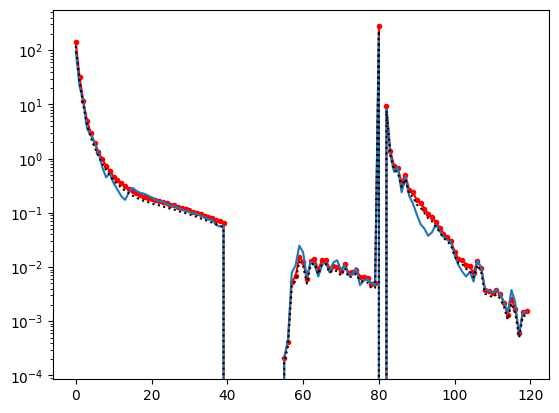

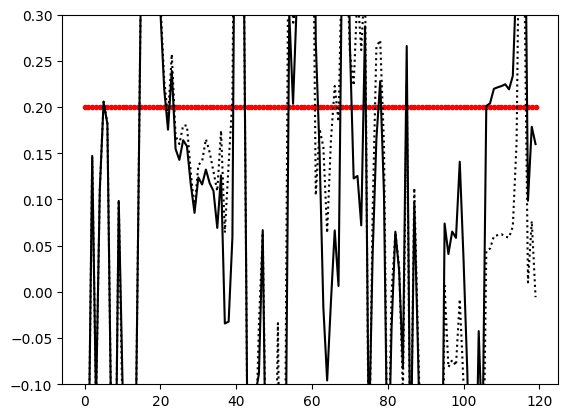

step: 13 0.5701543749999999
[[-2.5382550e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.3409492e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.1085888e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2194815e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.0027043e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.2557023e-08]]
[ 0.7154097   0.5901537   0.36108395 -0.17825282 -0.13145952 -0.11280334
 -0.08835075  0.06682327 -0.26463577 -0.48280042 -0.4348605  -0.17880931
 -0.41195732 -0.21433824  0.30186638  0.20283629  0.3147196   0.7716014
  0.9072591   0.96326476  0.78186965  0.27017725  0.15062356 -0.01688721
 -0.0959074  -0.01063594  0.06653979  0.00636697  0.39475617  0.5878391
  0.26785

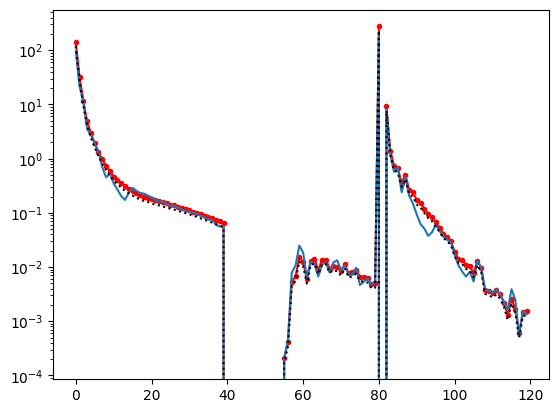

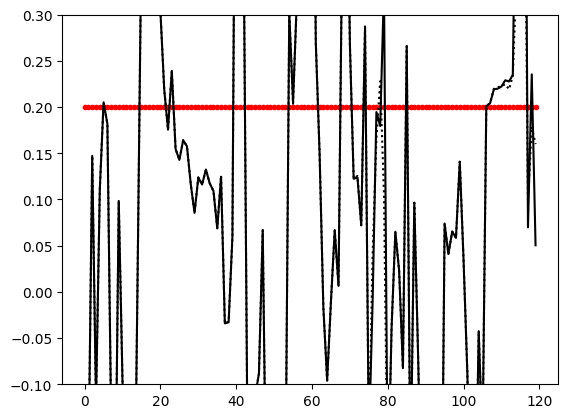

step: 16 0.5416466562499999
[[-3.0033472e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.2640717e-16  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8541840e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.0461690e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.9094734e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.2094293e-08]]
[ 7.15409696e-01  5.90153694e-01  3.61083955e-01 -1.78253904e-01
 -1.31462291e-01 -1.12805411e-01 -8.83520097e-02  6.68212995e-02
 -2.64638066e-01 -4.82803613e-01 -4.34867024e-01 -1.78816110e-01
 -4.11977470e-01 -2.14359969e-01  3.01775396e-01  2.05698535e-01
  3.16649258e-01  7.71670938e-01  9.07351673e-01  9.63299453e-01
  7.81909525e-01  2.70202279e-01  1.50663301e-0

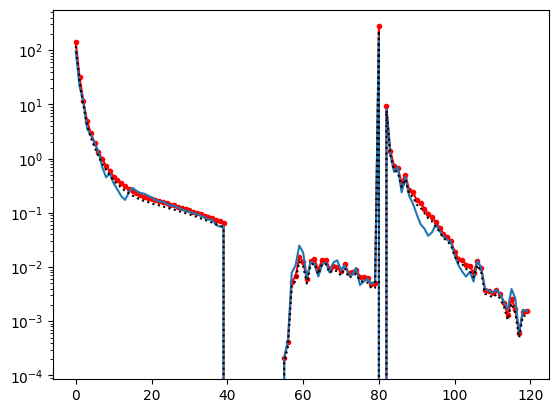

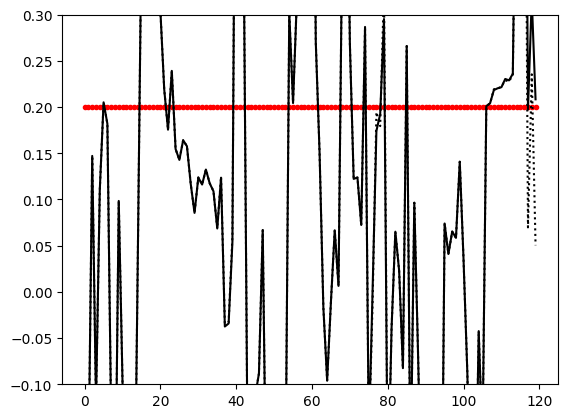

step: 19 0.5145643234374998
[[-2.9355757e-17  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.5628150e-18  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.6006978e-18 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.5695776e-11
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.2336781e-10  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -6.0885347e-10]]
[ 0.7154097   0.5901537   0.36108395 -0.17825377 -0.13146207 -0.11280499
 -0.08835135  0.06682201 -0.26463708 -0.4828019  -0.43486464 -0.17881292
 -0.4119708  -0.21434939  0.30182016  0.2043343   0.3157204   0.7716102
  0.9073116   0.9632814   0.7818868   0.27013475  0.15063284 -0.01687539
 -0.09593099 -0.01062734  0.06663709  0.00646109  0.395092    0.58823895
  0.2682

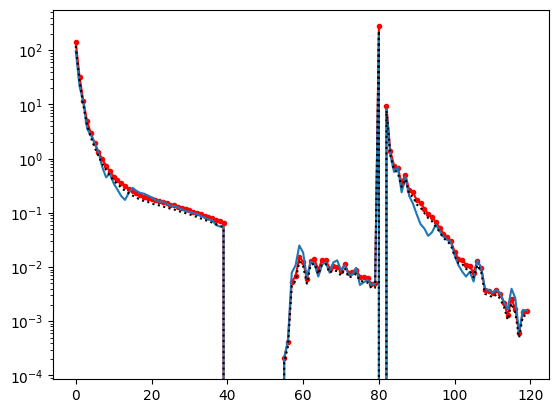

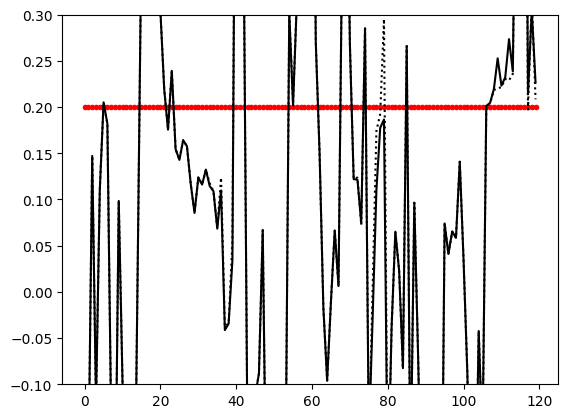

step: 22 0.48883610726562476
[[-2.8929459e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.7875528e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8435720e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1551580e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.6579586e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.1832344e-05]]
[ 0.5057711   0.39582253  0.19474722 -0.27867827 -0.23760442 -0.00438019
 -0.19976172 -0.06355194 -0.35450235 -0.54600465 -0.5039247  -0.27916124
 -0.48382175 -0.3103504   0.14282736  0.3485226   0.47481006  0.98798215
  1.1402764   1.2031353   0.9995901   0.42523715  0.29118517  0.10320476
  0.0144605   0.11018629  0.19688019  0.129256    0.5653811   0.78131205
  0.42

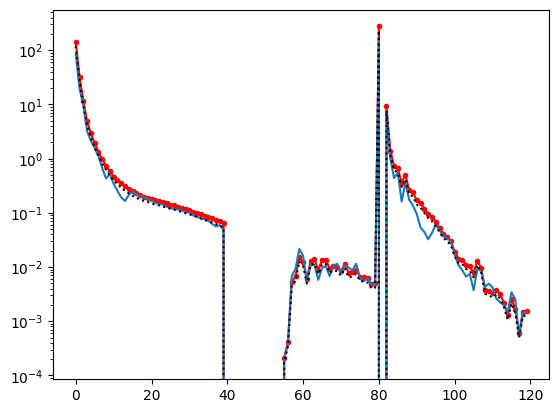

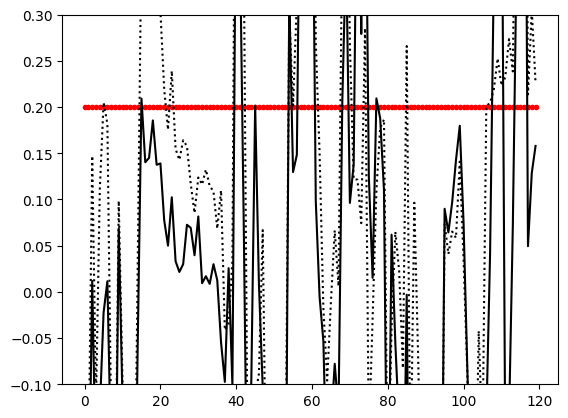

step: 25 0.4643943019023435
[[-5.0884742e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.3645193e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.4836675e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.3473764e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.7637714e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9700712e-05]]
[ 0.50468165  0.34762278 -0.00552274 -0.33240992  0.01241207  0.3204062
  0.12478478 -0.12600484 -0.21638785 -0.36188135 -0.4546002  -0.20748857
 -0.55056345 -0.39952192  0.40962073  0.10673778  0.10445448  0.35393718
  0.466043    0.50046957  0.36184308 -0.02932651 -0.00181007 -0.03319733
 -0.1637252  -0.07113984 -0.01868574 -0.2295621   0.1816422   0.21318233
  0.0319

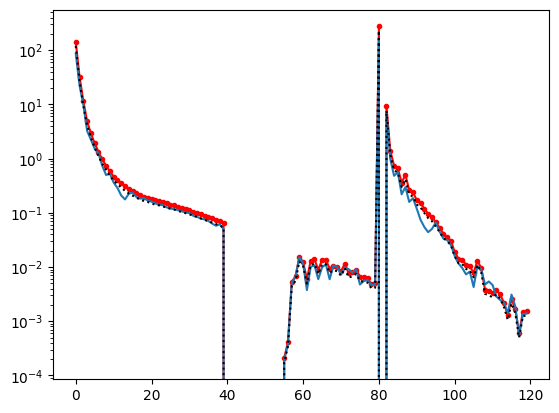

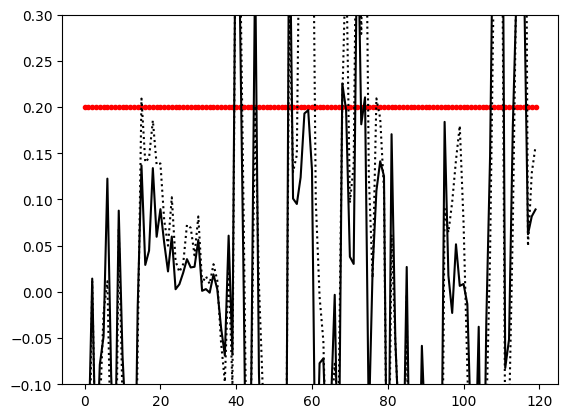

step: 28 0.44117458680722627
[[-1.7560758e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.1141478e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3980506e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.3717162e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.9473271e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0243229e-05]]
[ 5.01920640e-01  3.01576585e-01 -6.72216853e-03 -4.29070085e-01
 -1.85877398e-01  5.09204984e-01  1.30261602e-02 -1.70266584e-01
 -3.68606210e-01 -2.92782068e-01 -3.95541131e-01 -2.21952334e-01
 -6.05523169e-01 -3.42279464e-01  3.87997657e-01  8.97236317e-02
  1.00904353e-01  2.47935593e-01  3.24641287e-01  3.28619480e-01
  2.56695092e-01 -1.57987177e-01  2.45603714e-

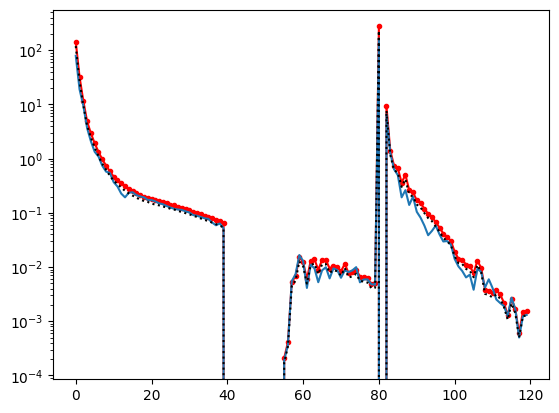

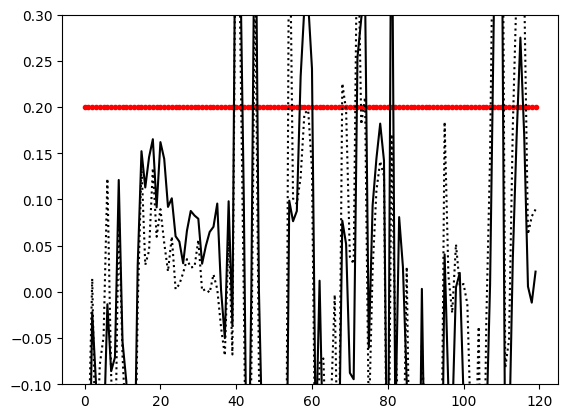

step: 31 0.4191158574668649
[[-7.5287068e-07  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.9444646e-09  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.1120998e-10 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0387025e-12
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -5.2528997e-12  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7783068e-11]]
[ 5.45708001e-01  3.80398899e-01  1.01795420e-01 -2.96201140e-01
  3.61530925e-03  4.90847230e-01  7.03849830e-04 -1.80359676e-01
 -3.76286298e-01 -3.01384062e-01 -4.02890831e-01 -2.31392786e-01
 -6.10373557e-01 -3.50291759e-01  9.86098275e-02  7.86957592e-02
  8.83355811e-02  2.32809708e-01  3.08734149e-01  3.12462538e-01
  2.41410941e-01 -1.68222293e-01  1.20906755e-0

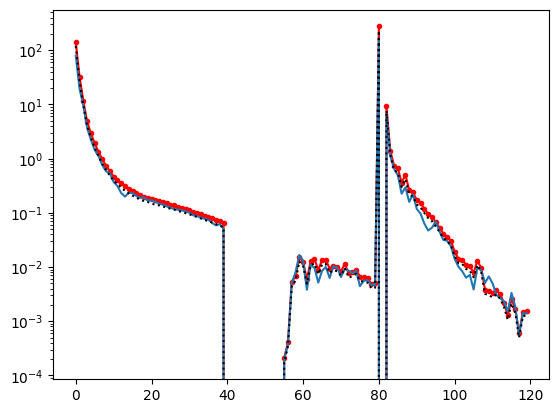

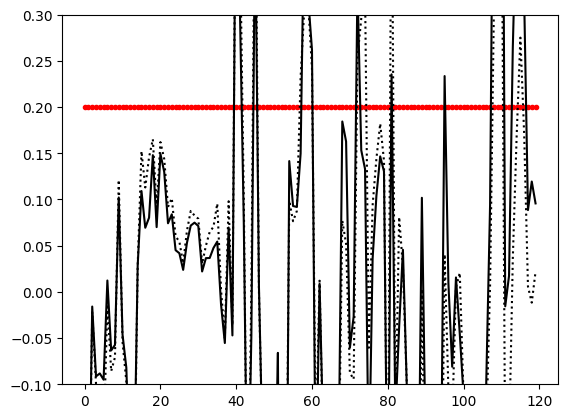

step: 34 0.39816006459352166
[[-5.9099369e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.3804589e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.0682580e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.6601555e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4505149e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1510599e-05]]
[ 0.53521186  0.2381819   0.05051907 -0.19174306  0.04773997  0.27399626
 -0.09421572 -0.26366428 -0.19849564 -0.06243728 -0.34375054 -0.15898558
 -0.65666336 -0.42748088  0.2551769   0.20173596  0.20058414  0.26432118
  0.5699179   0.44861242  0.38750738 -0.15299246  0.10915331 -0.0812396
 -0.23307453 -0.1671676  -0.02508168 -0.11672696  0.24450593  0.17996408
  0.033

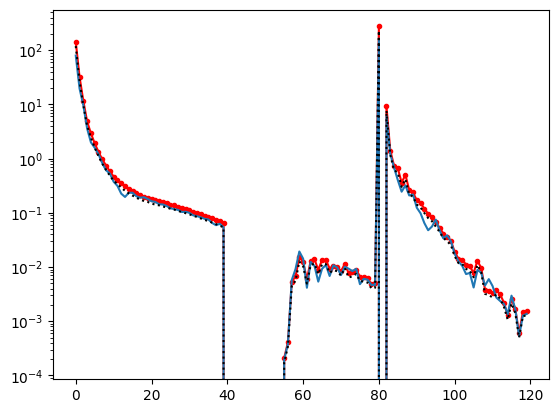

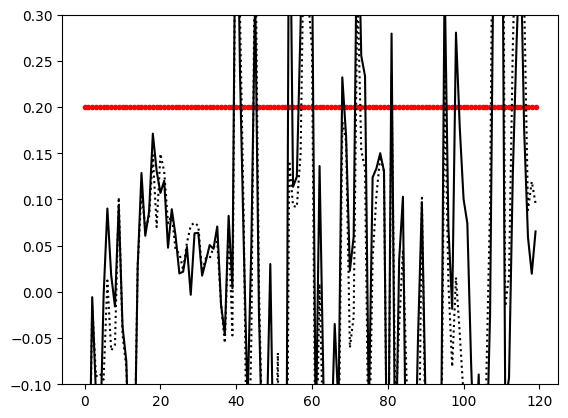

step: 37 0.37825206136384554
[[-1.16091705e-05  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.57668258e-08  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.78594414e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.08453048e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.34074753e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.02712545e-06]]
[ 0.5344431   0.23716894  0.04992309 -0.11941984  0.05115363  0.32350445
 -0.02933209 -0.18713032 -0.07761254  0.03313588 -0.16508125 -0.10735275
 -0.7258181  -0.47214514  0.5163493   0.10232133  0.07959808  0.29922614
  0.6738007   0.5282807   0.5036664  -0.08208279  0.23410869 -0.08713844
 -0.27375275 -0.25339428 -0.0997725  -0.159

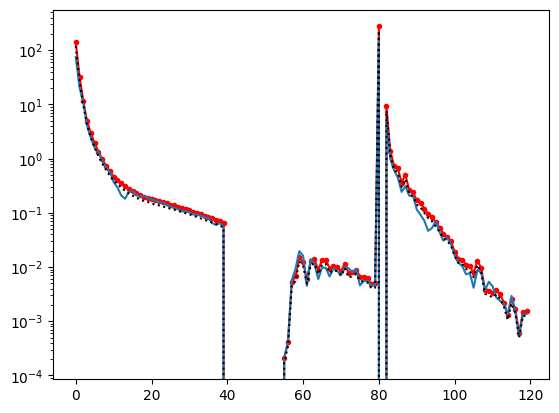

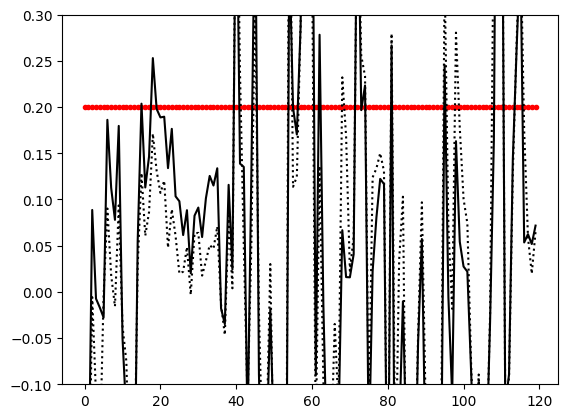

step: 40 0.3593394582956532
[[-7.8937206e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.3482724e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5650198e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.7223252e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.7591743e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1726730e-05]]
[ 0.48882565  0.1333917   0.12717573 -0.07745279  0.02809566  0.5719212
 -0.17103292 -0.32565236 -0.2462834   0.06993433 -0.24688137 -0.19480866
 -0.7526807  -0.48815945  0.49611077  0.09149535  0.06525412  0.17193606
  0.5099379   0.40927562  0.41663605 -0.17201453  0.16343687 -0.10221723
 -0.26162574 -0.2019299  -0.22552618 -0.22153926 -0.02910954 -0.07526506
 -0.0754

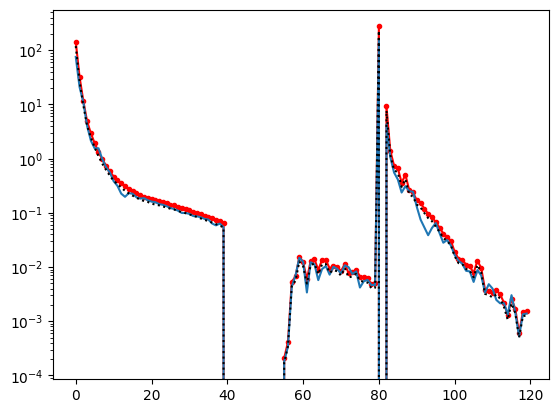

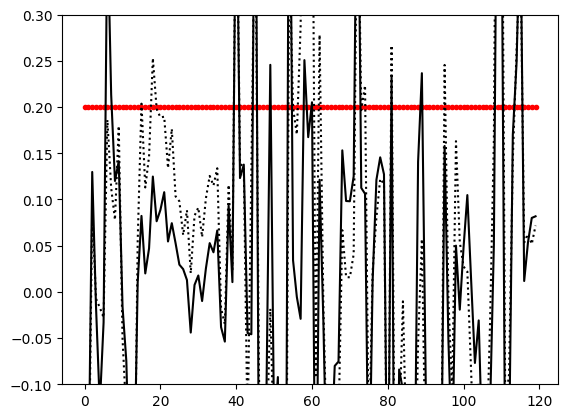

step: 43 0.34137248538087056
[[-2.5181419e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.1515381e-01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.8903784e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.2006900e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0460782e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0487221e-05]]
[ 0.4904735   0.07365349  0.15786599 -0.06488198 -0.12727042  0.56994724
 -0.15415981 -0.24125251 -0.02837975  0.28315824 -0.12310053 -0.03769749
 -0.7156317  -0.42166662  0.5556144   0.05316712  0.02100512 -0.04647856
  0.30896986  0.16777909  0.18814912 -0.3726335   0.0762516  -0.03872656
 -0.21444558 -0.14746591 -0.04278089 -0.15015242  0.19542201  0.14885503
  0.07

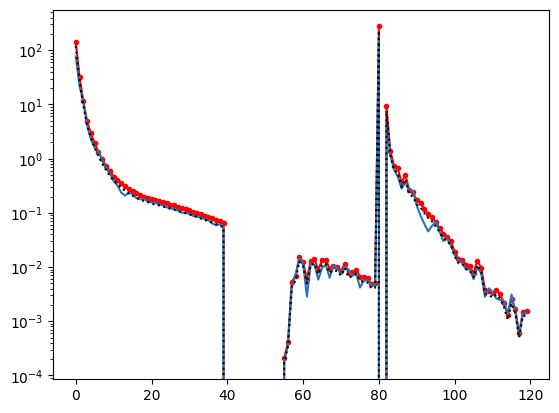

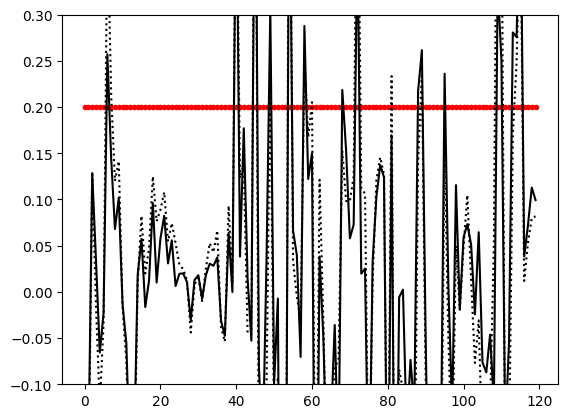

step: 46 0.324303861111827
[[-9.4834052e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -9.7069442e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.2846079e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.0146013e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.6001118e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0658614e-05]]
[ 0.48693126  0.03763798  0.17554562  0.07082396 -0.07048692  0.5585648
 -0.04600628 -0.16612391  0.05548876  0.3190766  -0.07944304  0.0256227
 -0.6867608  -0.388663    0.50187415  0.07478703  0.05008218 -0.09331515
  0.28156543  0.09429061  0.13653092 -0.47269836  0.02209146 -0.05110568
 -0.18555251 -0.1349252  -0.02363988 -0.2124039   0.22468153  0.12759951
  0.032797

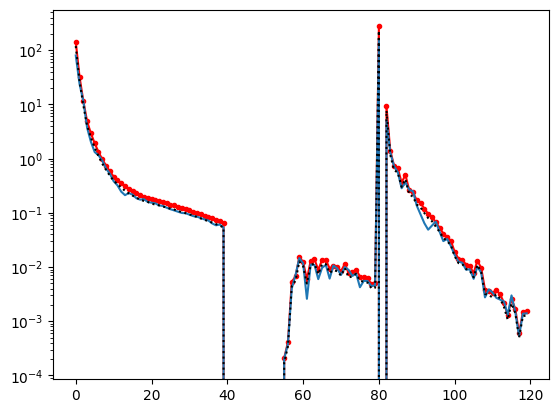

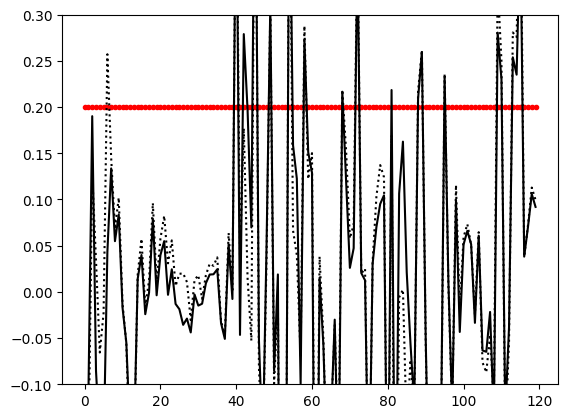

step: 49 0.30808866805623564
[[-4.4018429e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.5637394e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.3371815e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.8686841e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1711037e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6484029e-05]]
[ 0.5555351   0.02686577  0.3774908   0.10457104 -0.01268189  0.428685
 -0.12527281 -0.10780048  0.12931228  0.41133618 -0.01505693 -0.05959549
 -0.71278757 -0.4394585   0.37708467  0.2478605   0.20892158 -0.02989931
  0.37120134  0.2398764   0.2160228  -0.43581754  0.09357914  0.01526238
 -0.128588   -0.07441972  0.04464925 -0.15731737  0.31033888  0.2064666
  0.10503

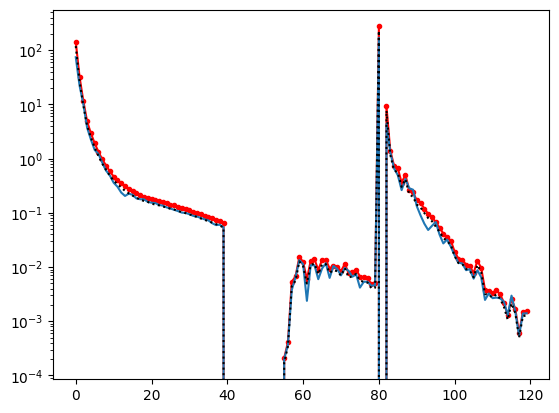

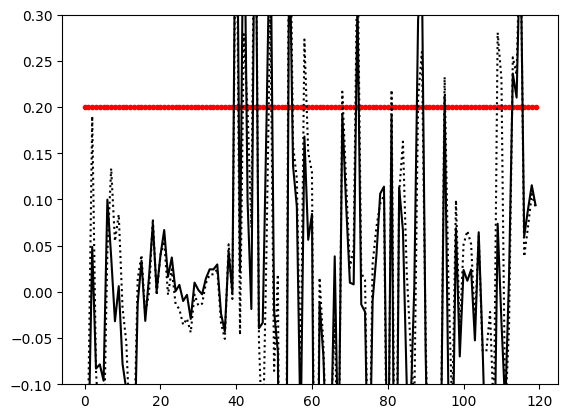

step: 52 0.29268423465342386
[[-2.49909282e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.10412115e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.89797964e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.01586675e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.42326457e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.00824124e-05]]
[ 0.46315607  0.03519294  0.5746661   0.01767512 -0.09035367  0.6143629
  0.03087859  0.03730502  0.27146998  0.5276267   0.05074179  0.0032278
 -0.6936005  -0.40201175  0.5081302   0.12186286  0.14087416 -0.0955163
  0.2535819   0.13370246  0.16369355 -0.48421216  0.06040784 -0.00074943
 -0.13411495 -0.10473245  0.1144366  -0.135094

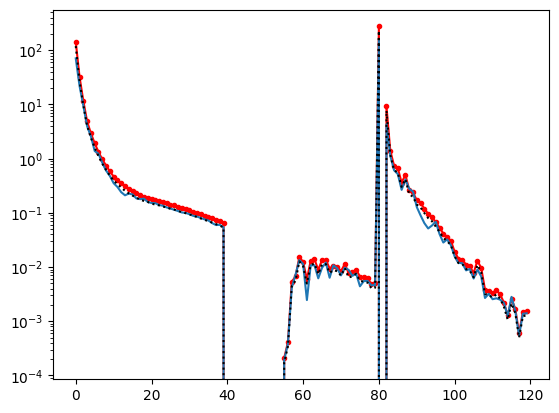

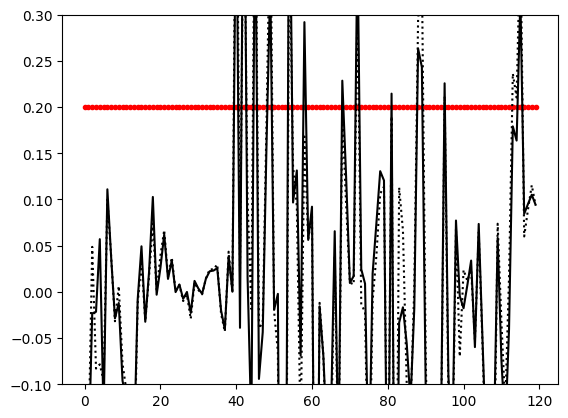

step: 55 0.27805002292075265
[[-2.1716467e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.7244913e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2481160e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0875594e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.8236642e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1110283e-05]]
[ 0.46639854 -0.0414935   0.53040606  0.03223526 -0.10805431  0.43664217
 -0.0904224  -0.05022976  0.13120027  0.24833106 -0.08660154 -0.06082933
 -0.71642554 -0.42779723  0.46747595  0.09489542  0.1134589  -0.09070087
  0.29461327  0.05389829  0.09329025 -0.519116   -0.02125905 -0.06772995
 -0.15775129 -0.13639994  0.0550109  -0.23655584  0.21812612  0.09134252
 -0.01

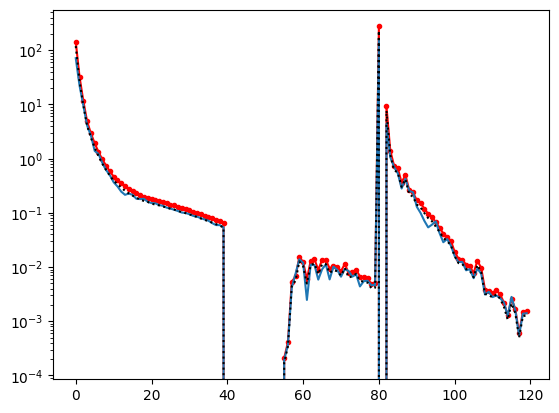

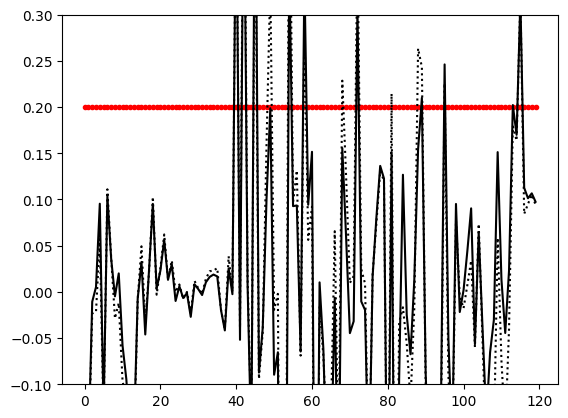

step: 58 0.264147521774715
[[-2.9042837e-09  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.6462187e-12  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2532885e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6255195e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -5.3755038e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.2204676e-08]]
[ 0.4693575  -0.051862    0.50302577  0.00747784 -0.1709823   0.52913374
 -0.0873298  -0.03888744  0.10025063  0.19871117 -0.0896437  -0.06537147
 -0.71783626 -0.43052936  0.3616396   0.10162722  0.08073949 -0.06442194
  0.3405568   0.09440611  0.15163131 -0.50004816  0.01031592 -0.06122082
 -0.20741384 -0.19490868  0.05276903 -0.24375951  0.15577342  0.06020289
 -0.0440

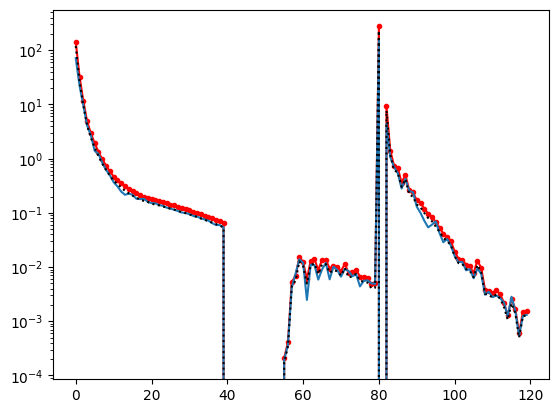

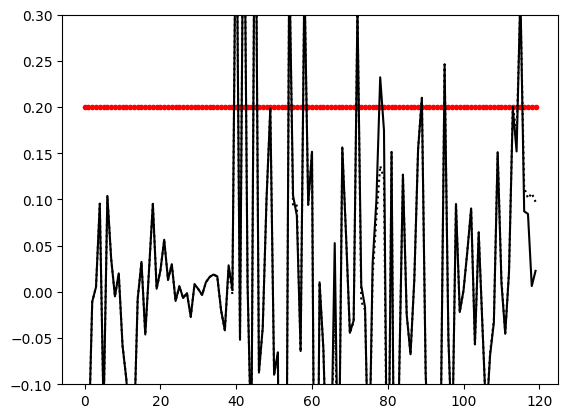

step: 61 0.2509401456859792
[[-1.8092357e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.5794749e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.4258476e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.4910370e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.5568611e-09  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.1923919e-08]]
[ 4.6935749e-01 -5.1862001e-02  5.0302559e-01  7.4770250e-03
 -1.7098583e-01  5.2912897e-01 -8.7333523e-02 -3.8890310e-02
  1.0024561e-01  1.9870712e-01 -8.9649595e-02 -6.5386727e-02
 -7.1785706e-01 -4.3054146e-01  3.6152643e-01  1.0446790e-01
  8.2655005e-02 -6.4034060e-02  3.4064138e-01  9.4441429e-02
  1.5166369e-01 -4.9991050e-01  1.0385343e-02 -6.1135929e-02
 -2.07

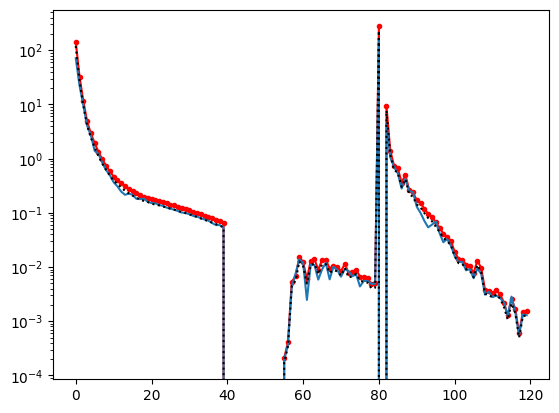

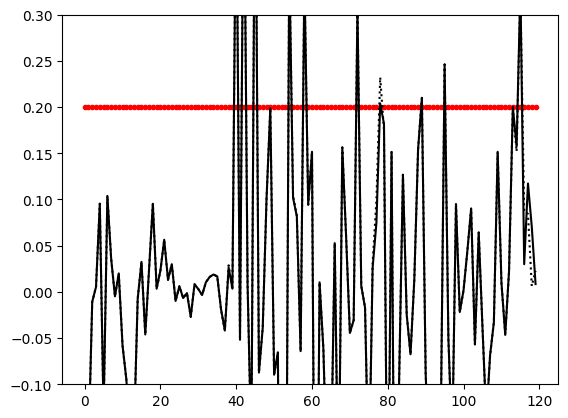

step: 64 0.23839313840168025
[[-6.9535936e-06  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.5583940e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.1796253e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.0110636e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.5131519e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0423422e-06]]
[ 0.4693596  -0.05185436  0.5030661   0.00696694 -0.17100438  0.529124
 -0.08734273 -0.03894755  0.10014807  0.19860128 -0.08972507 -0.06557604
 -0.71920323 -0.42991334  0.36413172  0.08413882  0.06324613 -0.06568194
  0.33966458  0.09392868  0.15101536 -0.50190747  0.00919396 -0.06167483
 -0.20843865 -0.19573003  0.04457489 -0.24352868  0.15484442  0.05846886
 -0.0483

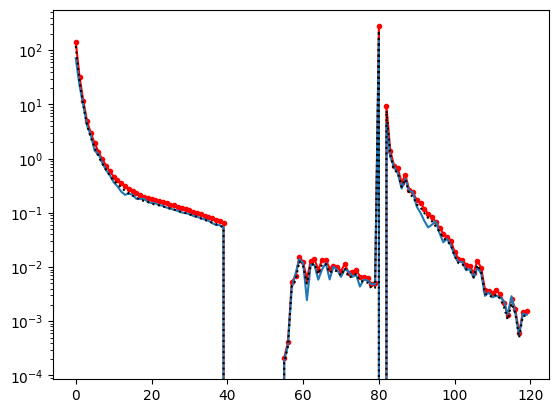

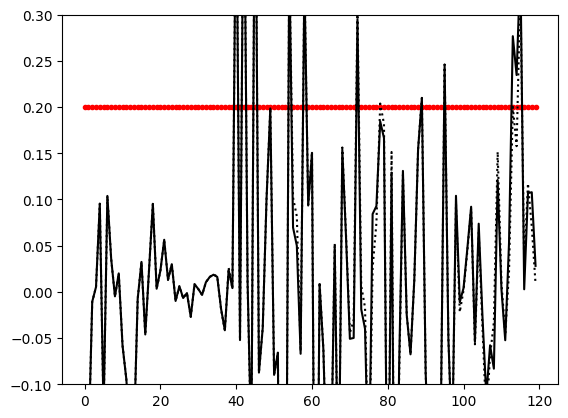

step: 67 0.22647348148159624
[[-5.8612128e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.0858253e-05  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.3132121e-06 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.5519538e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3054404e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.6011667e-06]]
[ 4.69322592e-01 -5.23088761e-02  5.02959549e-01  1.09285275e-02
 -1.71331525e-01  5.28948843e-01 -8.70396271e-02 -3.98293696e-02
  9.98225212e-02  1.98336571e-01 -8.99364948e-02 -6.59560636e-02
 -7.19915986e-01 -4.29901719e-01  3.56612176e-01  7.36897141e-02
  4.45403233e-02 -7.37761632e-02  3.27077538e-01  9.14859548e-02
  1.51689008e-01 -5.04942119e-01  8.98841210e-

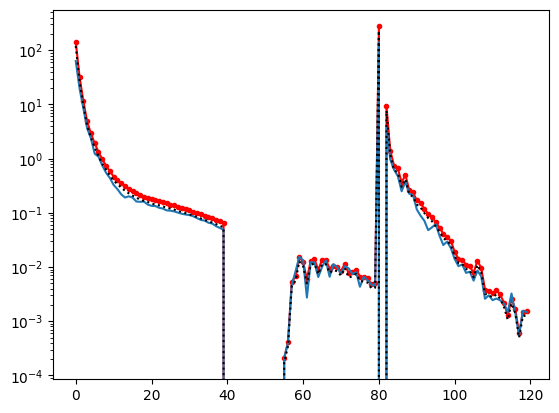

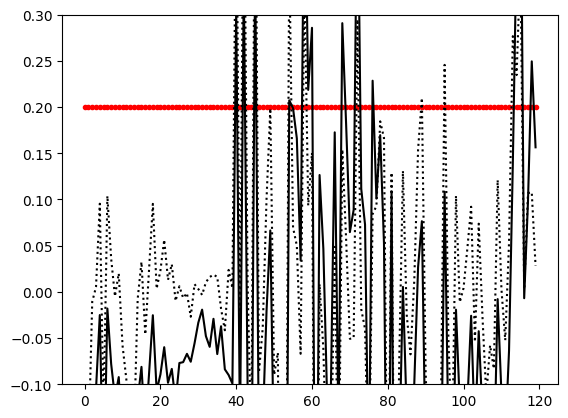

step: 70 0.2151498074075164
[[-4.0542170e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.9245468e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.8777854e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7128377e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.2073509e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.7495648e-05]]
[ 0.23731619 -0.11121918  0.40953267 -0.05191276 -0.3021784   0.28752738
 -0.23119627 -0.19144057 -0.07383974  0.00911898 -0.2336357  -0.21344186
 -0.7373266  -0.51992035  0.1424028   0.26318842  0.2288943  -0.02154468
  0.40191376  0.15303682  0.354954   -0.41756785  0.18706778  0.10269053
 -0.06934367 -0.0534076   0.23574224 -0.10909285  0.36024675  0.24576178
  0.121

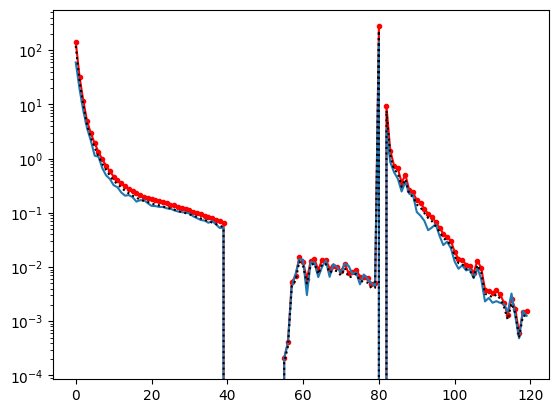

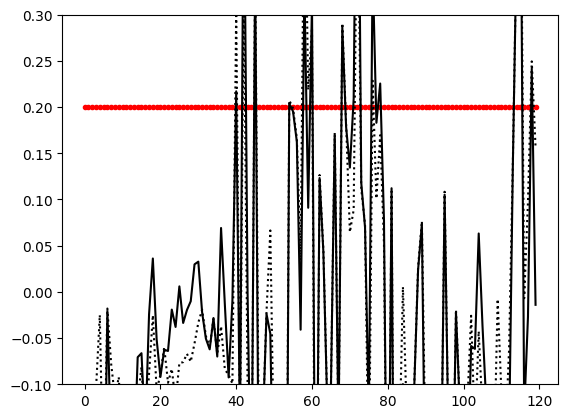

step: 73 0.2043923170371406
[[-1.2868815e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.8135735e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8154138e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.3005270e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3282999e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.7333374e-05]]
[ 0.21717872 -0.1602574   0.4842395  -0.035435   -0.25121522  0.34027267
 -0.2767207  -0.16750635 -0.05099906 -0.05620616 -0.2671974  -0.21765561
 -0.7387459  -0.52252567  0.25735274  0.17420845  0.14452913 -0.06119531
  0.30666554  0.07278512  0.28994772 -0.3827973   0.10137812  0.03187411
 -0.10806825 -0.1073185   0.1338543  -0.19698723  0.28464973  0.15026416
  0.094

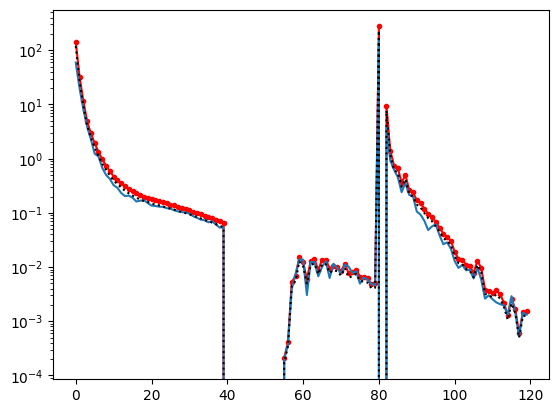

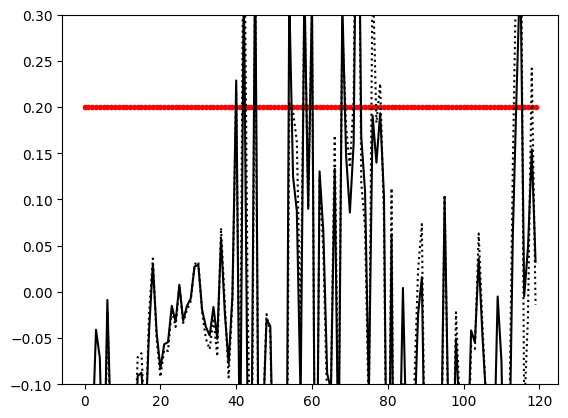

step: 76 0.19417270118528354
[[-9.8913443e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.8889793e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.2569469e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.1301390e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.7082944e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8693219e-05]]
[ 0.22618097 -0.24657273  0.3313033  -0.08872516 -0.15372118  0.36926687
 -0.21581736 -0.17975204 -0.07045997 -0.07425246 -0.26538232 -0.21911202
 -0.70705014 -0.46221718  0.32602134  0.11808692  0.08230508 -0.13689363
  0.31682932  0.07739162  0.30962464 -0.3545261   0.1249732   0.05909904
 -0.08528984 -0.10063701  0.13555124 -0.22310054  0.30046085  0.13611507
  0.06

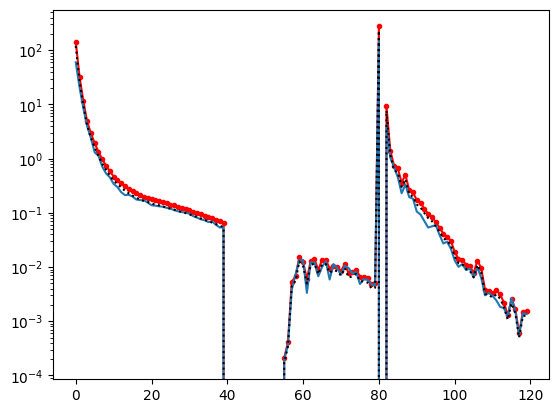

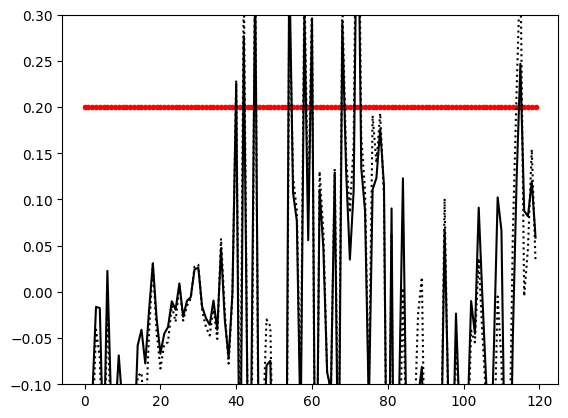

step: 79 0.18446406612601934
[[-1.7025812e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2470148e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.6624809e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.1740822e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.6319325e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9047955e-05]]
[ 0.22656663 -0.2745506   0.25199863 -0.11302139 -0.06281816  0.33885062
 -0.16598189 -0.2021242  -0.08947972 -0.06972948 -0.23337133 -0.13012114
 -0.67157555 -0.3913609   0.36396706  0.10551355  0.08502511 -0.13647474
  0.32862177  0.07028093  0.309694   -0.2958082   0.11280219  0.04749758
 -0.08306102 -0.10261837  0.12839423 -0.242685    0.29785764  0.15138374
  0.03

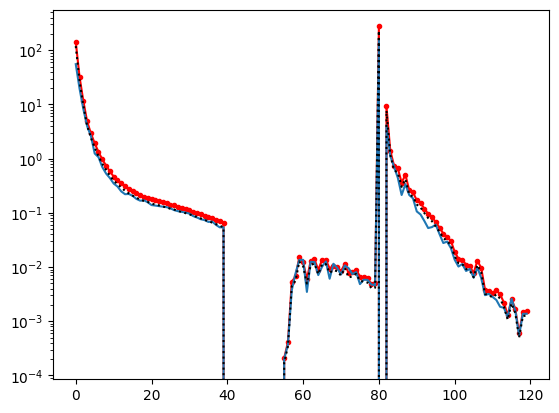

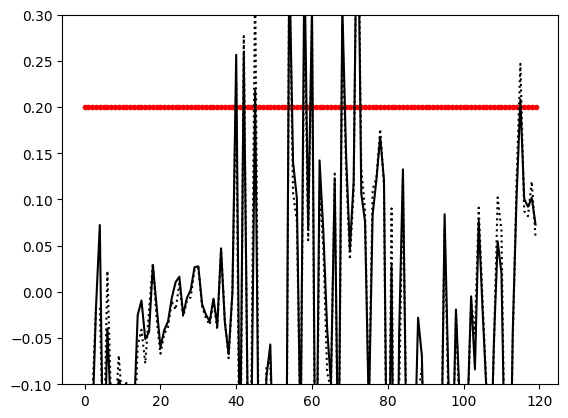

step: 82 0.17524086281971837
[[-6.0586914e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.7392510e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.3390434e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.6574167e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.8245926e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9340227e-05]]
[ 0.25668362 -0.20468792  0.22981428 -0.1378286  -0.14202626  0.1931091
 -0.23957533 -0.21488708 -0.11434902 -0.08204109 -0.22113797 -0.11527488
 -0.6941415  -0.38853994  0.36684433  0.13053237  0.0940811  -0.15978295
  0.35978213  0.06168686  0.30572936 -0.28410178  0.1365072   0.06240554
 -0.03275036 -0.0916136   0.12706076 -0.23784363  0.30031818  0.13785145
  0.034

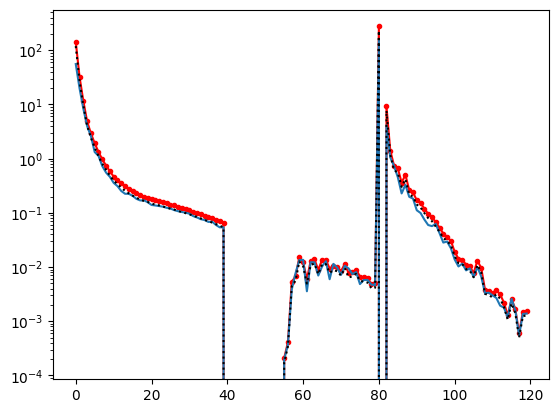

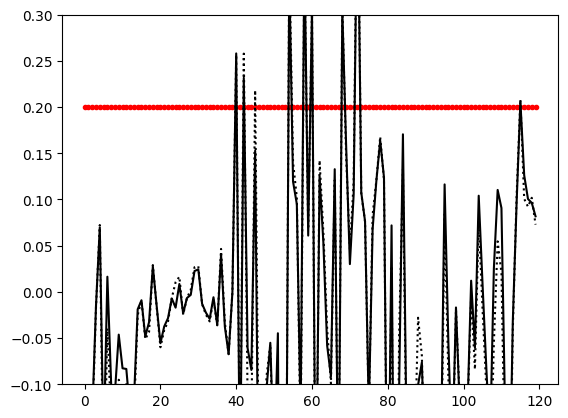

step: 85 0.16647881967873246
[[-1.5155783e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2232585e-08  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5284019e-09 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.4078040e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1152428e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0555094e-06]]
[ 0.25806096 -0.22716412  0.23169912 -0.06058379 -0.08460079  0.15276964
 -0.26615843 -0.22508739 -0.10551862 -0.05495158 -0.1870627  -0.04571912
 -0.6782477  -0.3888355   0.34277618  0.1068084   0.08371062 -0.13694082
  0.3748055   0.06057854  0.30527714 -0.27922976  0.12386736  0.05099434
 -0.05874737 -0.09067515  0.131982   -0.23691083  0.2995688   0.16282597
  0.03

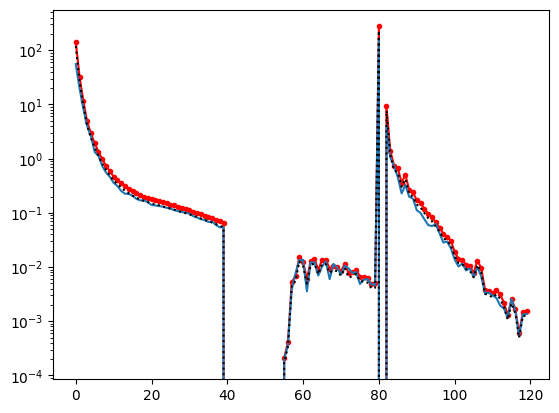

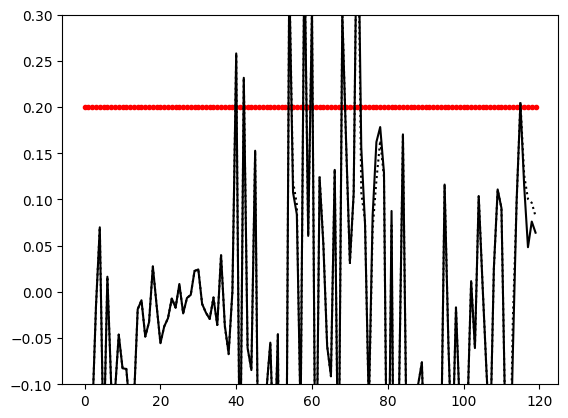

step: 88 0.15815487869479583
[[-1.9796454e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.5225031e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4609165e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.6782637e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.3974278e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1013806e-08]]
[ 0.25806096 -0.22716412  0.23169905 -0.06058393 -0.08460102  0.15276943
 -0.26615837 -0.22508767 -0.10551885 -0.05495184 -0.18706213 -0.04571905
 -0.6782476  -0.38883623  0.34277266  0.1071258   0.08360679 -0.13696073
  0.37481833  0.06057773  0.30527553 -0.27924708  0.12386455  0.05100311
 -0.05875266 -0.09068374  0.13202262 -0.23689704  0.29953313  0.16277015
  0.03

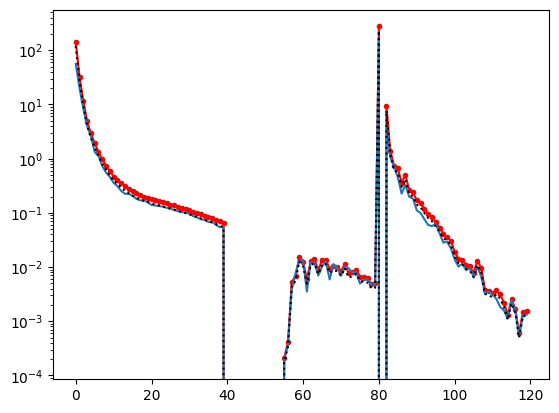

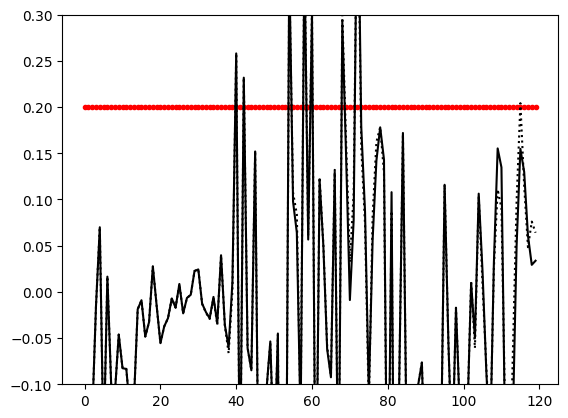

step: 91 0.15024713476005602
[[-4.0354123e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.6592361e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.6835854e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.7144067e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -5.6028366e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6115299e-08]]
[ 0.25806874 -0.22730643  0.23183765 -0.06077402 -0.08485524  0.15196148
 -0.26603442 -0.2257111  -0.10547652 -0.0536309  -0.18442939 -0.04504629
 -0.6799307  -0.39248306  0.3560199   0.09758462  0.0640155  -0.14486258
  0.3685762   0.05664368  0.30078486 -0.28619534  0.12168663  0.04965995
 -0.06192906 -0.09243868  0.12938307 -0.24592495  0.29200304  0.14723097
 -0.00

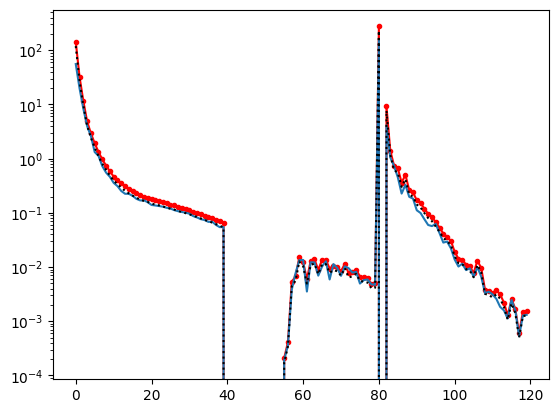

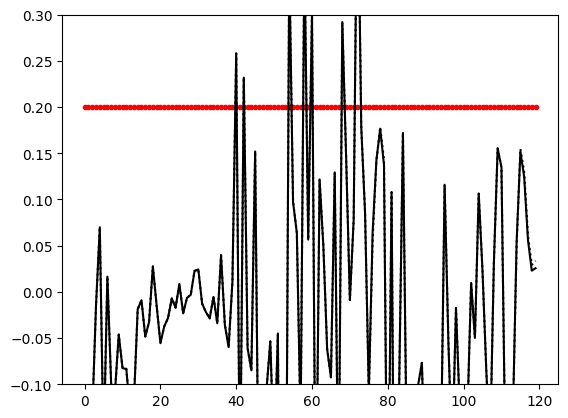

step: 94 0.14273477802205323
[[-4.4796210e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.5257940e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.8783054e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.1926882e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.6235098e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -9.9070533e-08]]
[ 0.25806874 -0.22730643  0.23183765 -0.06077408 -0.08485565  0.15196033
 -0.2660348  -0.2257111  -0.10547714 -0.0536322  -0.18442966 -0.04504802
 -0.67993206 -0.39248395  0.3559957   0.09813462  0.06418233 -0.14483806
  0.36858517  0.05665602  0.3007937  -0.28611144  0.12170318  0.04966855
 -0.06191824 -0.09242577  0.1293834  -0.24592459  0.29201484  0.14724965
 -0.00

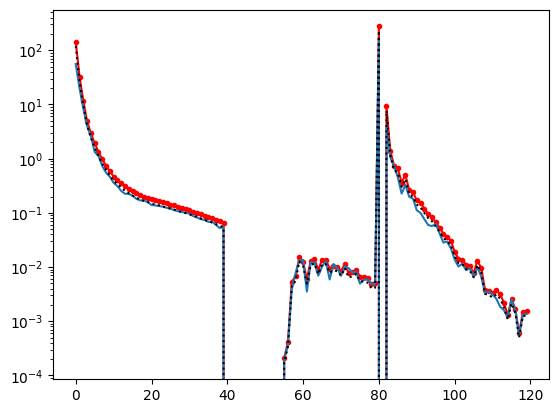

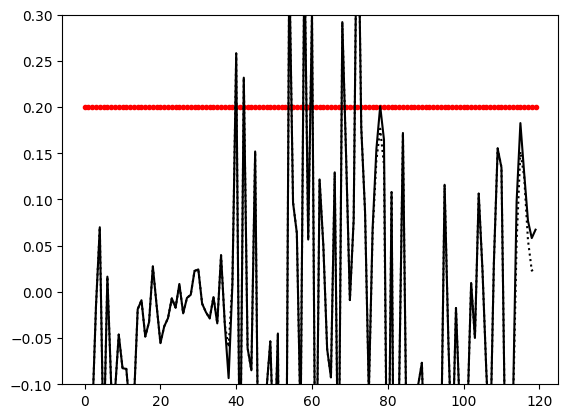

step: 97 0.13559803912095056
[[-4.6426498e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.6938922e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.7149395e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.3499425e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1372346e-09  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.8614194e-08]]
[ 0.25806874 -0.22730643  0.23183765 -0.06077388 -0.08485524  0.15196095
 -0.26603416 -0.22570994 -0.10547544 -0.05362946 -0.18442671 -0.04504362
 -0.6799251  -0.39247638  0.35603938  0.09618626  0.06356616 -0.14487872
  0.36855468  0.05664361  0.30077234 -0.28617743  0.12168262  0.04965127
 -0.06196164 -0.09246258  0.12934071 -0.24605137  0.29190725  0.14718382
 -0.00

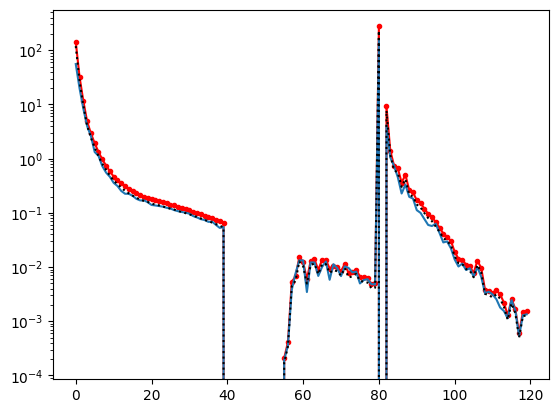

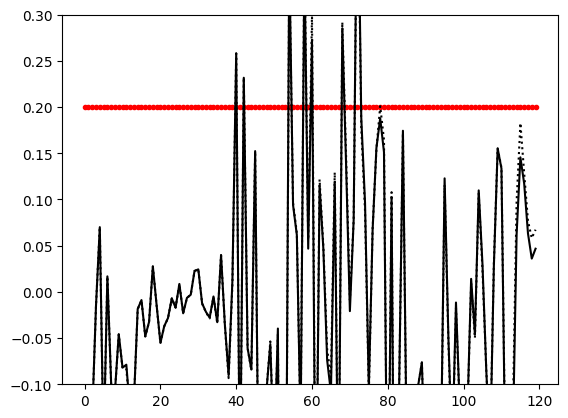

step: 100 0.12881813716490303
[[-5.3319037e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.6552845e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0034823e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.1723022e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.0814307e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.4027622e-07]]
[ 0.25811902 -0.2273699   0.2317509  -0.06081732 -0.08408859  0.15236618
 -0.25982916 -0.22597559 -0.10620546 -0.05645474 -0.18375893 -0.03967206
 -0.6712272  -0.37744156  0.3672217   0.09378578  0.06144791 -0.1499181
  0.36223152  0.04679509  0.27270353 -0.30084205  0.11517677  0.04651832
 -0.07390951 -0.10895683  0.11882246 -0.25579256  0.2853053   0.13754655
 -0.02

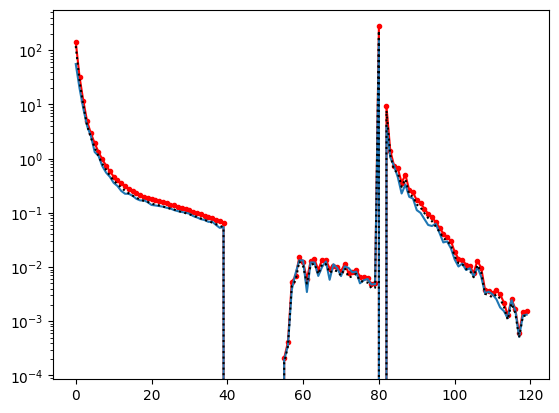

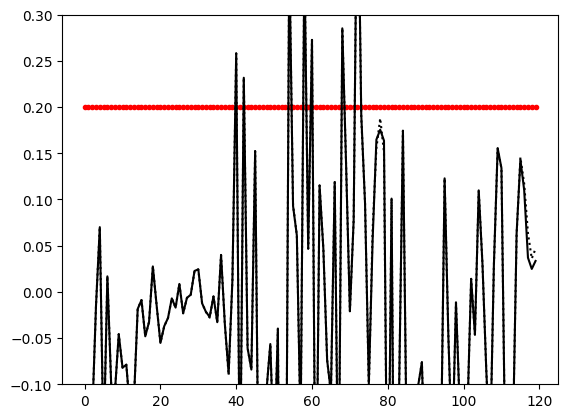

step: 103 0.12237723030665788
[[-1.7387572e-11  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.9646563e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.5917221e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7353350e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.6591882e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -7.3789107e-07]]
[ 0.25811777 -0.2273699   0.2317509  -0.06081834 -0.08412395  0.15236266
 -0.2598414  -0.22597209 -0.10620669 -0.05645239 -0.18376942 -0.03970891
 -0.6712653  -0.37746018  0.36702713  0.09943166  0.06749881 -0.14932197
  0.36272112  0.04690854  0.27265352 -0.30040523  0.11521652  0.04655369
 -0.07265757 -0.10879846  0.11887008 -0.25523013  0.28527567  0.13057187
 -0.0

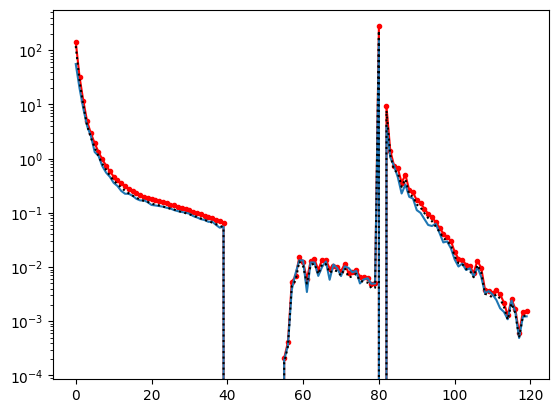

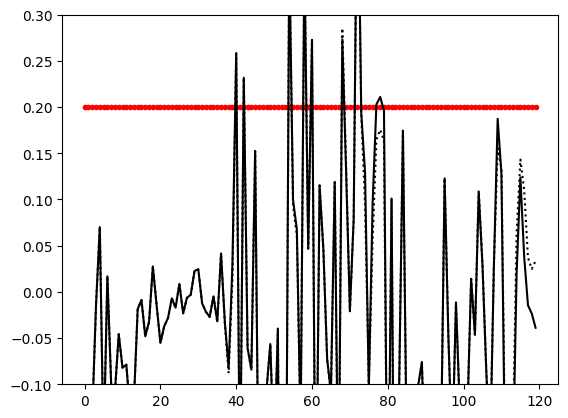

step: 106 0.11625836879132498
[[-4.3191637e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.0326644e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.6778812e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.6792768e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3504927e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8469887e-08]]
[ 0.25811777 -0.2273699   0.23175098 -0.06081842 -0.08412469  0.15236276
 -0.25984156 -0.22597119 -0.10620522 -0.05645121 -0.18376915 -0.03970798
 -0.67126596 -0.37745965  0.36703435  0.09933268  0.06762949 -0.14931233
  0.362709    0.04690501  0.27263805 -0.30040717  0.11521703  0.04655217
 -0.0726672  -0.10879482  0.11886416 -0.2552053   0.27326018  0.1304907
 -0.01

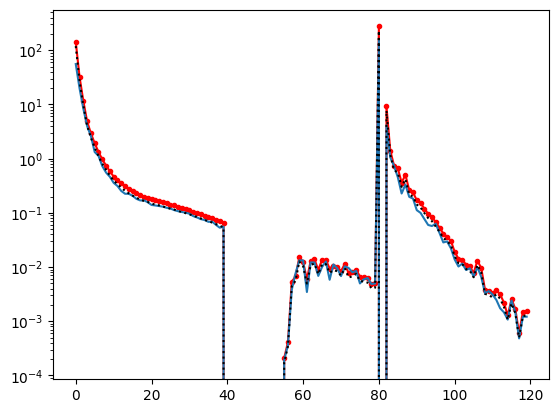

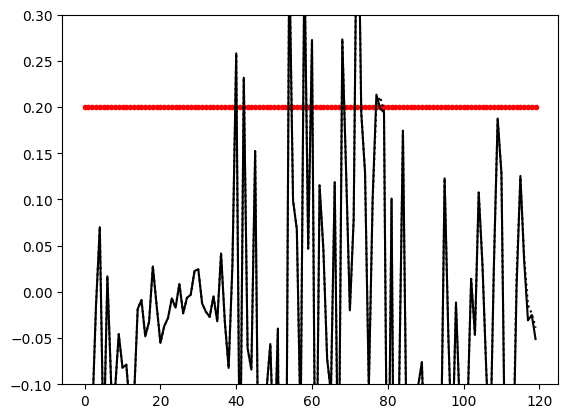

step: 109 0.11044545035175872
[[-1.5727242e-13  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.1073174e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4369638e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5671265e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3247896e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.1540737e-07]]
[ 0.25811777 -0.2273699   0.23175098 -0.06081998 -0.0841266   0.15236174
 -0.259844   -0.22597541 -0.10620963 -0.05645624 -0.18377836 -0.03971951
 -0.67129475 -0.37750268  0.366842    0.10290597  0.07206399 -0.1492234
  0.3628406   0.04696354  0.2726613  -0.30014336  0.11551613  0.04664196
 -0.07259096 -0.1087395   0.11933587 -0.25328332  0.27353835  0.13068394
 -0.01

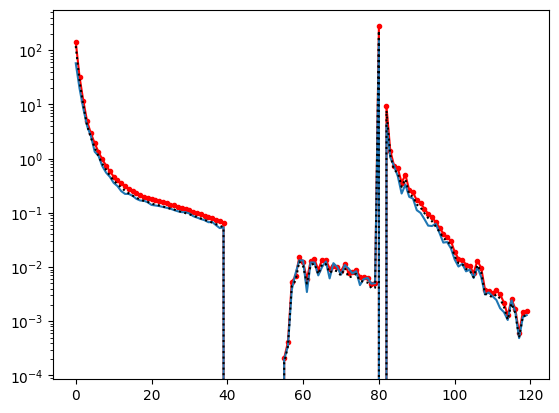

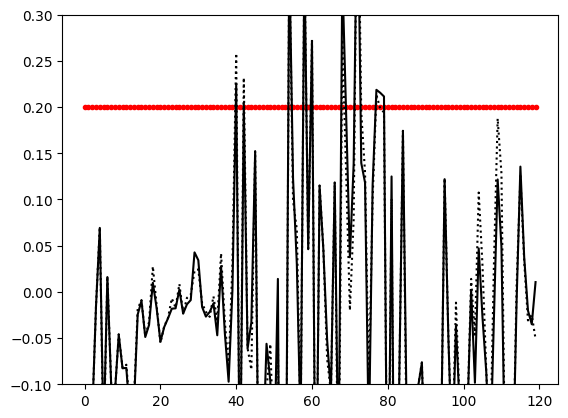

step: 112 0.10492317783417078
[[-3.29740703e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.63557011e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.97353261e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.00050129e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.14554405e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.85956887e-05]]
[ 0.22559063 -0.23097332  0.20241651 -0.08615265 -0.05357045  0.15790485
 -0.25407135 -0.17207661 -0.05254969 -0.08550932 -0.17335992  0.04064102
 -0.64378726 -0.34604362  0.32997388  0.12204849  0.04203073 -0.1275725
  0.392951    0.04641752  0.2512293  -0.31902078  0.10038665  0.03568454
 -0.06822067 -0.13277969  0.09813271 -0.220

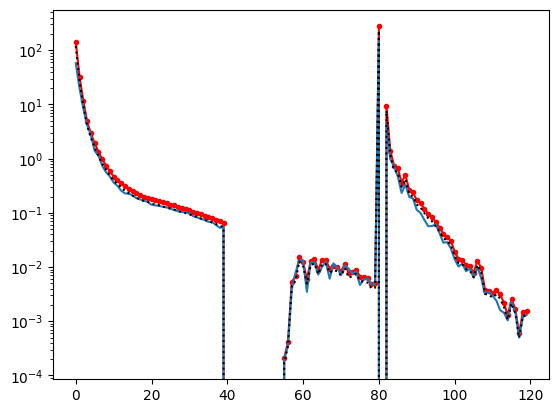

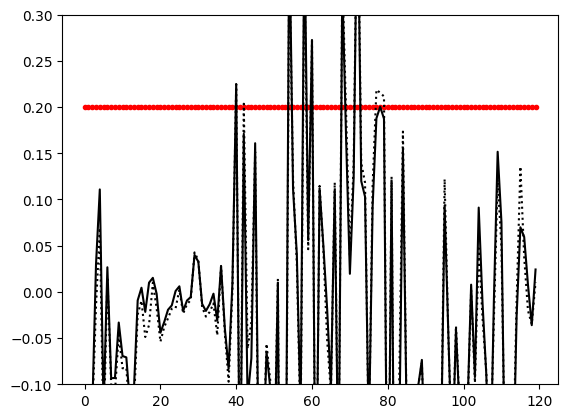

step: 115 0.09967701894246224
[[-8.5151982e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.1394884e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.8609801e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1337742e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3516470e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9530109e-05]]
[ 0.22734612 -0.25285137  0.17214599 -0.094614   -0.08583112  0.18140888
 -0.20558791 -0.18955572 -0.05683634 -0.0818921  -0.18074916  0.03525513
 -0.62795043 -0.29933402  0.39698845  0.11019406  0.04890005 -0.11329722
  0.43814042  0.07109135  0.27999723 -0.28552413  0.11002742  0.04867345
 -0.02439434 -0.11094199  0.10334413 -0.22959584  0.33236364  0.17272899
  0.0

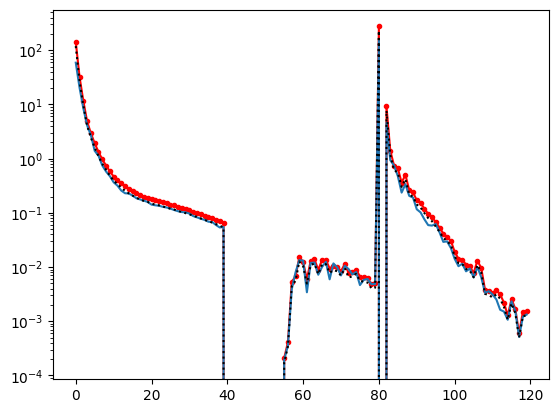

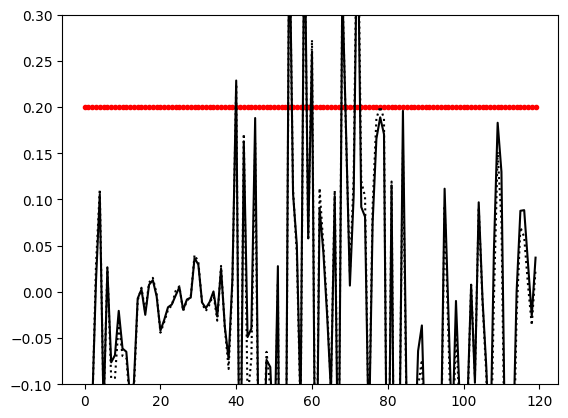

step: 118 0.09469316799533913
[[-1.3803059e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.7104063e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.5619633e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1069496e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2578129e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0616348e-05]]
[ 0.23994471 -0.26146486  0.13536502 -0.0264137  -0.01696928  0.16002712
 -0.22487594 -0.19094336 -0.05168058 -0.05970832 -0.16274534  0.00350121
 -0.6369837  -0.31634593  0.37830094  0.11080696  0.0668209  -0.10602316
  0.45420203  0.08290921  0.2898859  -0.29208332  0.10924073  0.04723239
 -0.02745199 -0.12337669  0.09208759 -0.2485022   0.3246584   0.16011891
  0.0

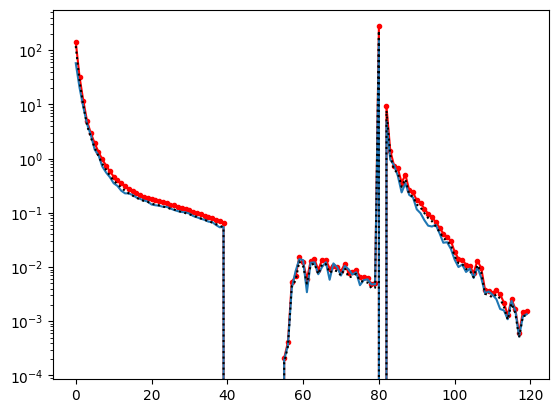

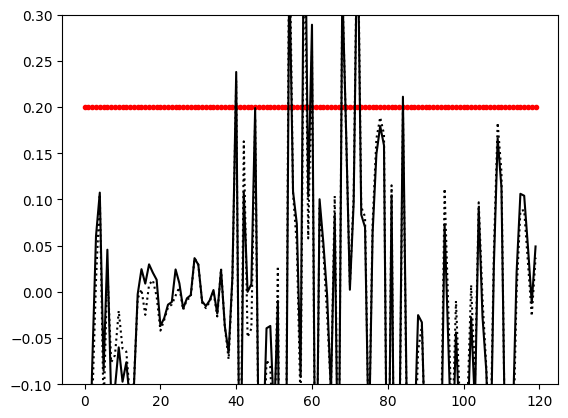

step: 121 0.08995850959557217
[[-1.6104423e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.6437002e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3581977e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1362876e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4247154e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9722134e-05]]
[ 2.38019407e-01 -2.92985648e-01  1.08575493e-01  2.25441176e-02
  3.11012957e-02  1.89654231e-01 -1.92377552e-01 -1.81906849e-01
 -3.50201018e-02 -2.67910082e-02 -1.34164199e-01 -1.32741760e-02
 -6.38822198e-01 -3.09659928e-01  3.58767062e-01  1.07114650e-01
  7.52182081e-02 -8.53421167e-02  4.91969347e-01  1.07562996e-01
  2.89124310e-01 -3.01502645e-01  9.80838761e

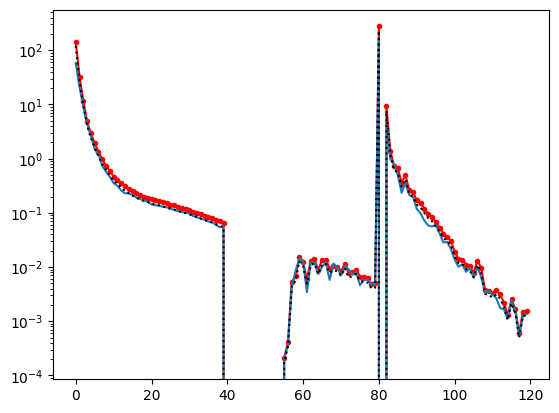

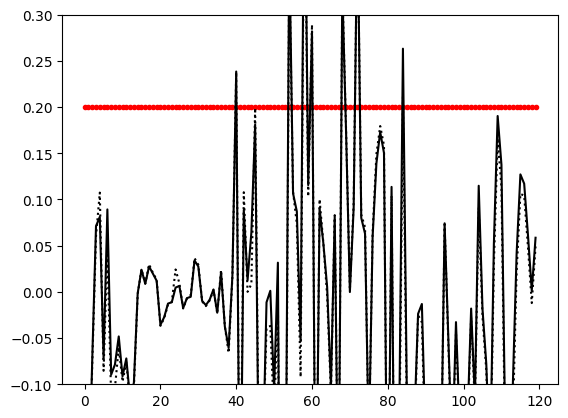

step: 124 0.08546058411579356
[[-2.4792682e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.8600238e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0879868e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1278641e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4448609e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9936642e-05]]
[ 2.38219157e-01 -3.22740555e-01  7.73498416e-02  3.43207642e-02
  8.68532807e-02  1.97913840e-01 -2.14822605e-01 -1.86596870e-01
 -4.76063276e-03  6.51768036e-03 -1.08079679e-01  2.58441381e-02
 -6.20725572e-01 -2.81006694e-01  3.77660364e-01  1.04754515e-01
  8.23876485e-02 -7.37729147e-02  4.82618093e-01  9.93671194e-02
  2.75752604e-01 -3.06275517e-01  8.72490630e

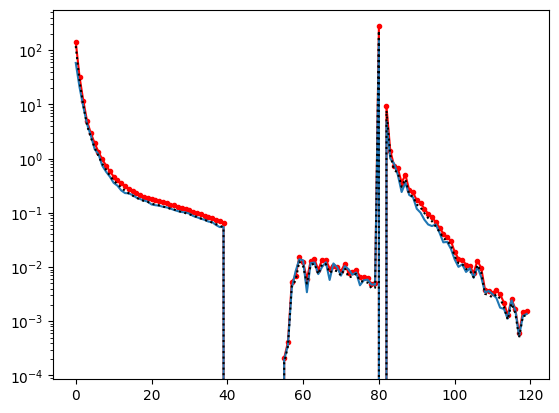

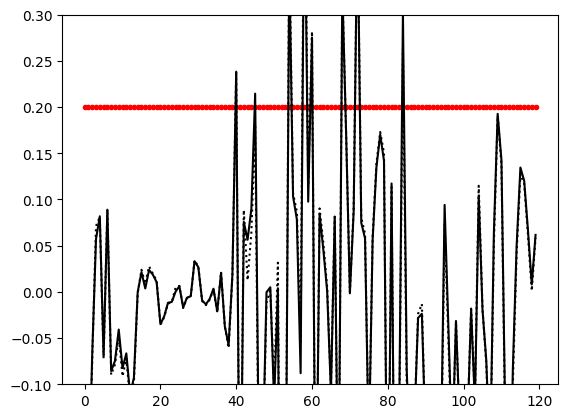

step: 127 0.08118755491000387
[[-7.5903469e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.4055901e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.2239572e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.7192793e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.1589953e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.7490431e-08]]
[ 2.38345310e-01 -3.21704179e-01  7.58348256e-02  5.64190000e-02
  8.98295566e-02  2.14545369e-01 -1.98047265e-01 -1.80120051e-01
 -3.76670709e-04  5.02424780e-03 -1.18255675e-01  3.93081596e-03
 -6.28826261e-01 -2.96362281e-01  3.58884722e-01  1.03195861e-01
  7.85899833e-02 -8.79756659e-02  4.74007815e-01  9.76118967e-02
  2.75327384e-01 -3.07243049e-01  8.45264122e

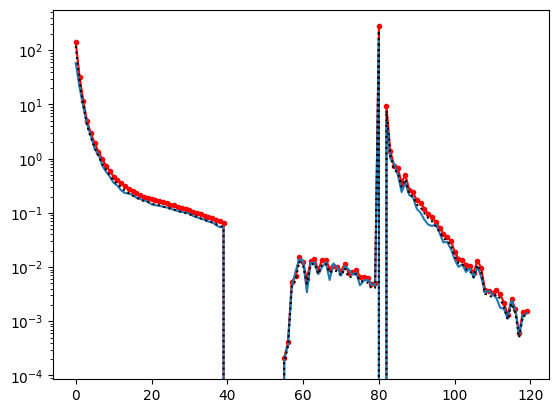

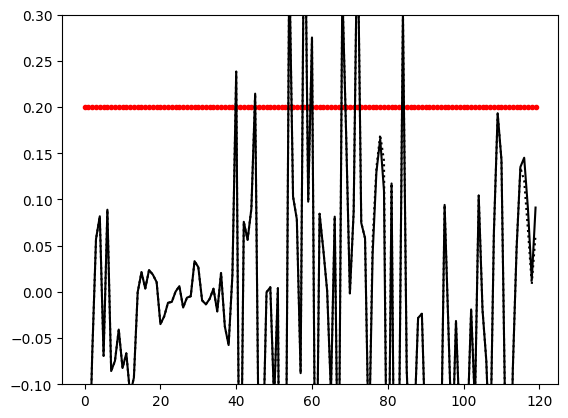

step: 130 0.07712817716450368
[[-1.3731674e-10  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.4210806e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.3240741e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1541844e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.5850636e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.8517445e-06]]
[ 2.38345310e-01 -3.21704179e-01  7.58348256e-02  5.64190000e-02
  8.98295566e-02  2.14545682e-01 -1.98046923e-01 -1.80119962e-01
 -3.76516226e-04  5.02418261e-03 -1.18254751e-01  3.93228186e-03
 -6.28825009e-01 -2.96359658e-01  3.58905405e-01  1.02671862e-01
  7.82957003e-02 -8.79966170e-02  4.73985225e-01  9.76023525e-02
  2.75316834e-01 -3.07260931e-01  8.45204443e

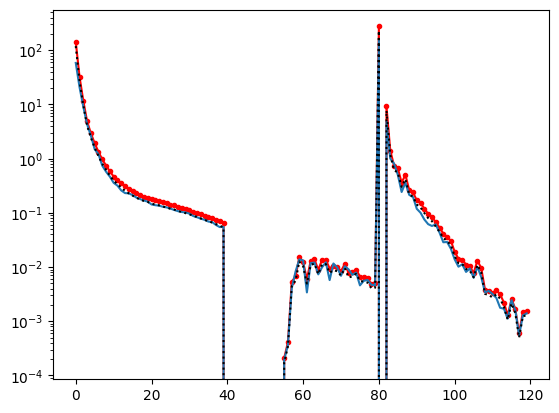

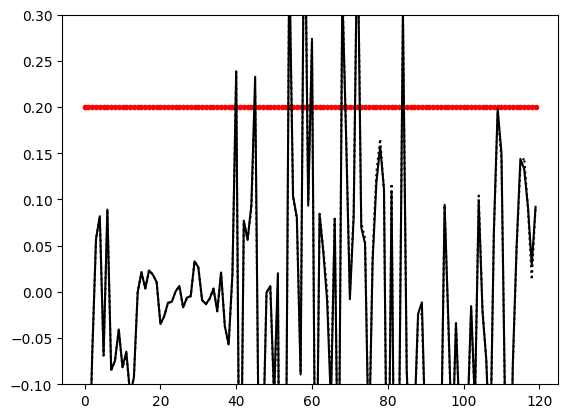

step: 133 0.07327176830627849
[[-3.1303608e-17  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4975841e-17  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.9107380e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1551796e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -6.4550214e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -8.7498492e-08]]
[ 0.23854718 -0.32165813  0.07713288  0.0565524   0.09373503  0.23287925
 -0.19767177 -0.17999561 -0.000631    0.00629397 -0.11269084  0.02020843
 -0.62395304 -0.28822905  0.3637632   0.1036      0.08084772 -0.08938577
  0.4672777   0.09334479  0.27147907 -0.31239888  0.08394535  0.04277453
 -0.01019588 -0.1208549   0.07923155 -0.26604772  0.3262454   0.16823532
 -0.0

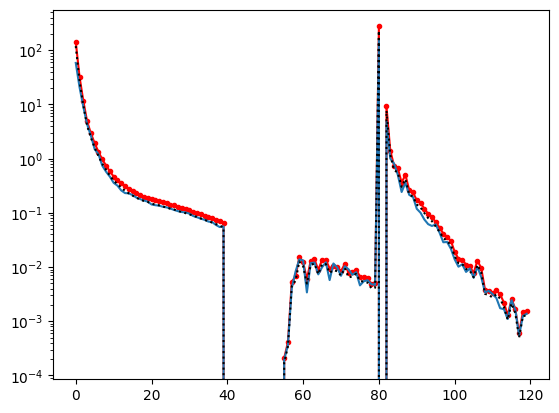

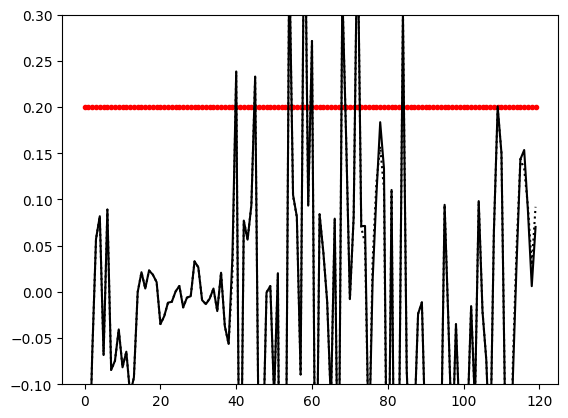

step: 136 0.06960817989096456
[[-6.6996308e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.8061629e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.1937394e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.0661152e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.4679581e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.7607840e-08]]
[ 0.23854704 -0.32165813  0.07713288  0.05655233  0.09373445  0.23287626
 -0.19767688 -0.17999624 -0.00063216  0.00629246 -0.11269148  0.02020776
 -0.62395394 -0.2882318   0.36373922  0.1047588   0.0813444  -0.08933529
  0.46730465  0.09335455  0.2714768  -0.31233191  0.08395678  0.04278225
 -0.01016286 -0.12083588  0.07924636 -0.2659912   0.32639486  0.16797768
 -0.0

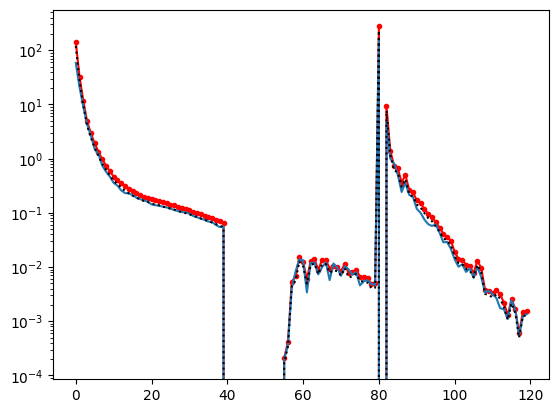

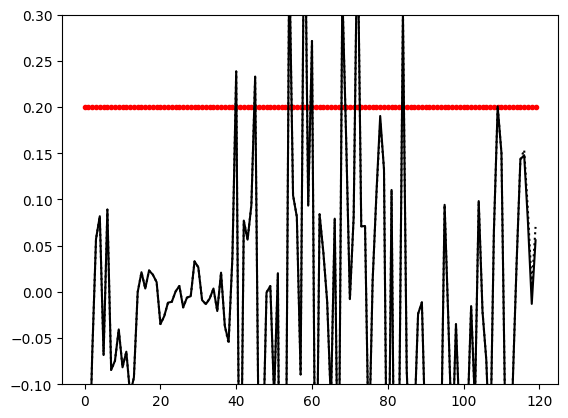

step: 139 0.06612777089641633
[[-3.2199866e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3488932e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.2225662e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9208523e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.8741823e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.1510144e-05]]
[ 0.23854704 -0.32165813  0.07713288  0.05655233  0.09373445  0.23287646
 -0.19767661 -0.17999588 -0.00063154  0.00629325 -0.1126902   0.02020916
 -0.62395155 -0.28822953  0.36375156  0.10436314  0.08115335 -0.08935288
  0.467292    0.0933489   0.27146894 -0.3123524   0.08394987  0.04277493
 -0.01017405 -0.12084556  0.07923057 -0.26603737  0.32633346  0.16793132
 -0.0

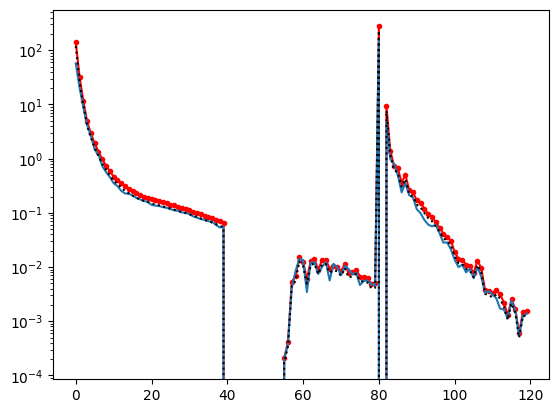

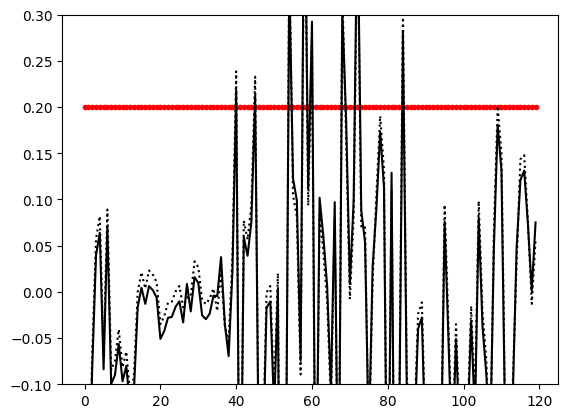

step: 142 0.06282138235159551
[[-1.8724915e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3838354e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.0121335e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0283125e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.0616519e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8684925e-05]]
[ 0.2223565  -0.32239518  0.07596303  0.02276761  0.05875888  0.1934526
 -0.2233339  -0.18088678 -0.0017173   0.00519987 -0.14106451 -0.01241497
 -0.63597697 -0.31099057  0.32014084  0.11812139  0.09721924 -0.08883585
  0.4681244   0.09396892  0.27219    -0.31196213  0.09787091  0.07666213
  0.02199248 -0.0922756   0.08219519 -0.28950745  0.3177036   0.2047209
  0.005

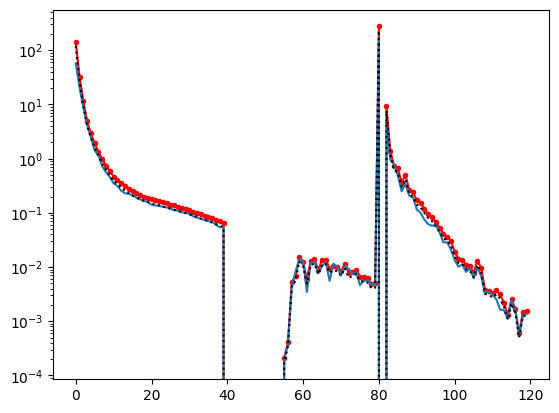

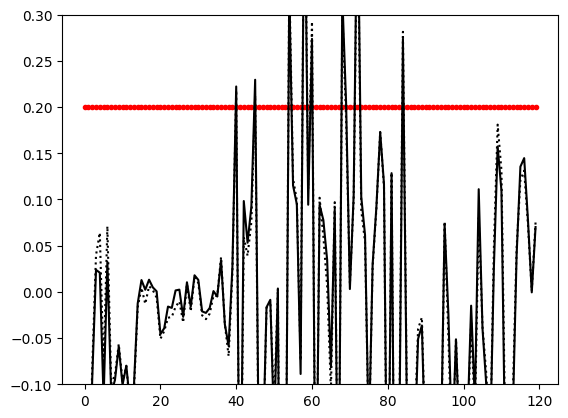

step: 145 0.059680313234015736
[[-1.7716521e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.7663414e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3306569e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1288672e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4587678e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0609225e-05]]
[ 0.2225037  -0.33186987  0.10775381  0.06888783  0.10857321  0.22448118
 -0.1867919  -0.18017443 -0.02623472 -0.01726577 -0.14953998  0.00617453
 -0.6259353  -0.29470646  0.3392672   0.11386339  0.0939374  -0.09090807
  0.47620323  0.08869731  0.26657686 -0.311607    0.08948941  0.07397292
  0.02111969 -0.0891052   0.08652108 -0.29283252  0.31793588  0.20090105
  0.

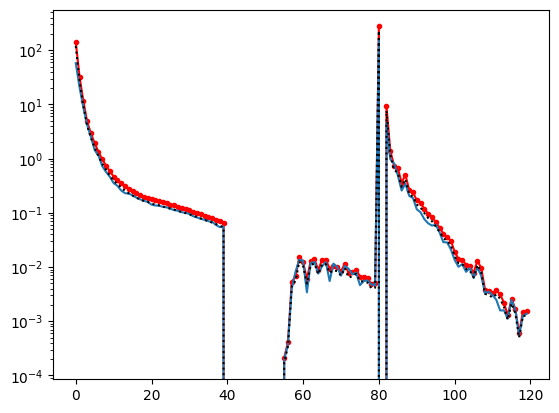

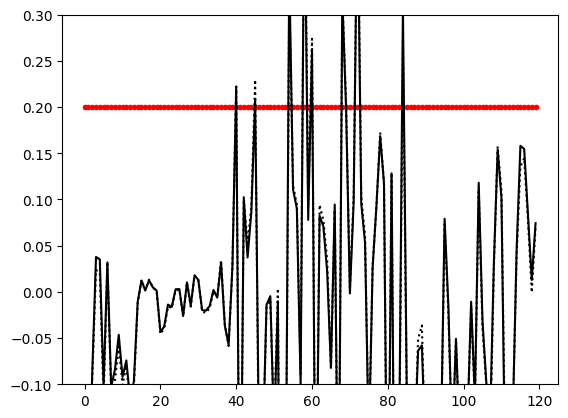

step: 148 0.056696297572314945
[[-9.6448696e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.6821687e-01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.5647527e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1316066e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4567576e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0608546e-05]]
[ 0.22191139 -0.3483826   0.09915464  0.05193181  0.07122457  0.21850958
 -0.1604065  -0.1770129  -0.02145185 -0.01040665 -0.15442818 -0.00545086
 -0.6269413  -0.2886168   0.34899962  0.10977222  0.08930778 -0.10192148
  0.4639556   0.07687241  0.25785694 -0.31763044  0.07733314  0.06820623
  0.01576968 -0.0877005   0.09227997 -0.2986796   0.31810468  0.19645429
 -0.

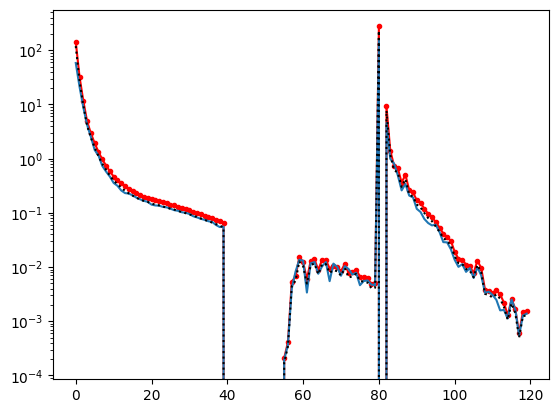

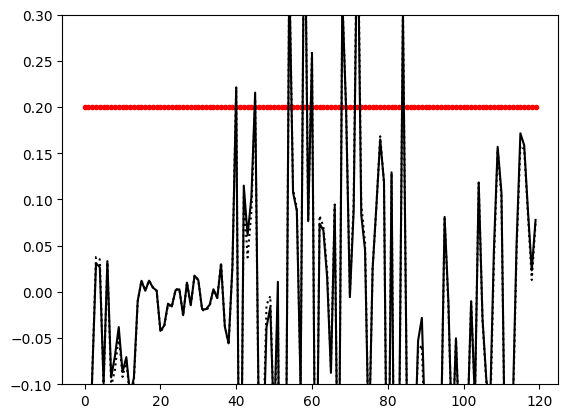

step: 151 0.0538614826936992
[[-4.6494281e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.5847052e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.9594280e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1376433e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4521492e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0650283e-05]]
[ 0.22184978 -0.3499791   0.12998626  0.04696698  0.11664324  0.23201732
 -0.14286369 -0.17564069 -0.02515924 -0.00348552 -0.13811402  0.00359484
 -0.61947596 -0.2750765   0.35464847  0.10727696  0.08732553 -0.10281906
  0.4731392   0.07988391  0.25857657 -0.30745494  0.07502457  0.06810623
  0.02192952 -0.0816356   0.09664025 -0.29376516  0.3204122   0.20161568
 -0.00

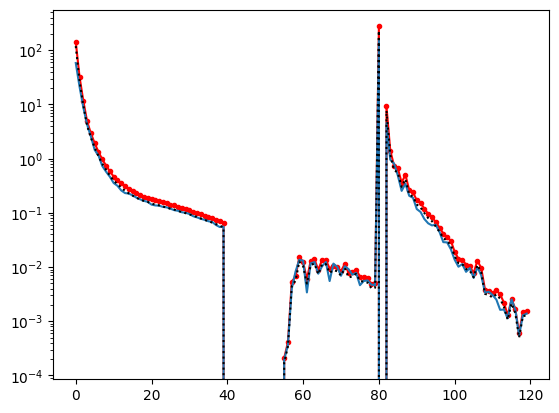

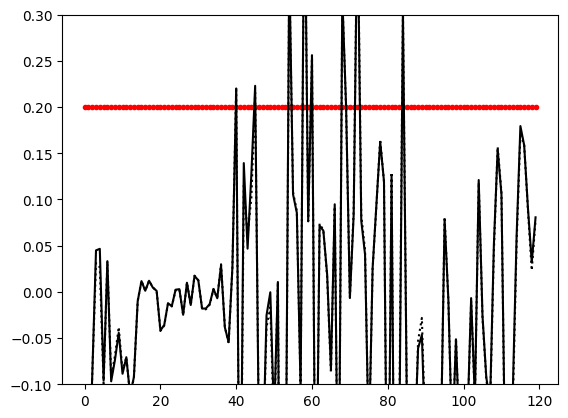

step: 154 0.051168408559014236
[[-1.1584047e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.9776910e-01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.1756200e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1368787e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4600742e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0643187e-05]]
[ 0.22273552 -0.32986957  0.15395032  0.03338672  0.11305104  0.23864664
 -0.1549857  -0.17706269 -0.0129242   0.01236865 -0.1274177  -0.00223405
 -0.6193602  -0.2796352   0.3398174   0.10542254  0.08631607 -0.10146363
  0.48249015  0.080202    0.25725818 -0.3067056   0.07189663  0.06695399
  0.01964213 -0.08552687  0.09338133 -0.29250556  0.320575    0.2029275
 -0.0

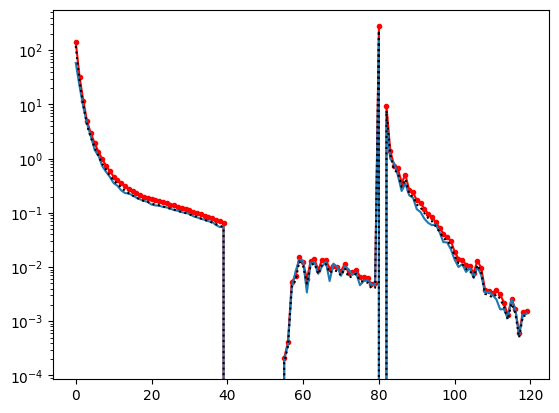

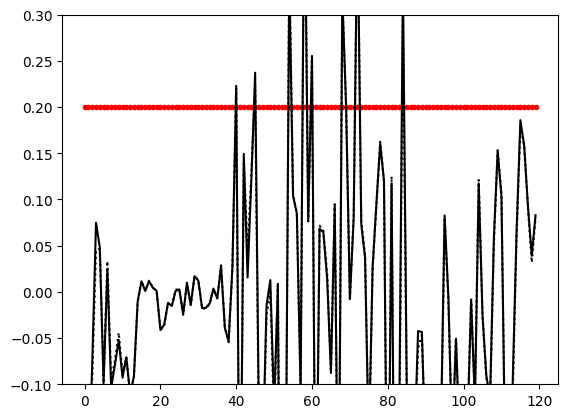

step: 157 0.04860998813106352
[[-2.2256892e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.1359959e-01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.5044298e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1317528e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4682024e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0652611e-05]]
[ 0.22067884 -0.33251175  0.14078496  0.02799103  0.13545553  0.23820677
 -0.1513065  -0.18197171 -0.00999819  0.01525502 -0.1266703  -0.00115341
 -0.61762875 -0.27788126  0.33709398  0.1037165   0.08442537 -0.1062733
  0.478046    0.07763628  0.25470394 -0.30989376  0.06810942  0.06475271
  0.01702817 -0.08585485  0.09302707 -0.29516444  0.31987002  0.20172209
 -0.00

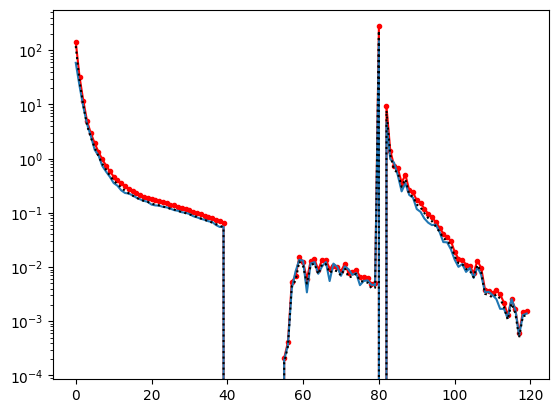

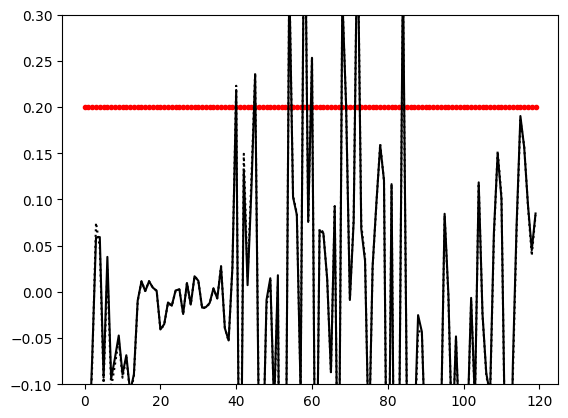

step: 160 0.046179488724510345
[[-5.0859356e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2842779e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.5735175e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.8605778e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.0799107e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6327609e-08]]
[ 0.21857682 -0.34863648  0.13207492  0.00726214  0.10992824  0.23539247
 -0.15733863 -0.18942554 -0.00873564  0.01473782 -0.12437609  0.01800803
 -0.6133651  -0.27218863  0.34078357  0.10262782  0.08329388 -0.10904135
  0.47457683  0.07568662  0.25333032 -0.31135783  0.06625927  0.06360642
  0.01469455 -0.08697698  0.09252212 -0.29561543  0.31985548  0.20192422
 -0.

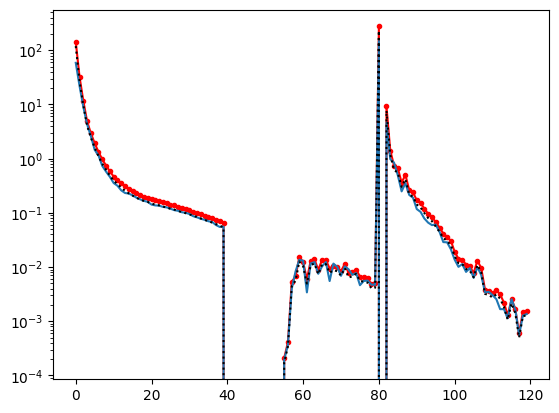

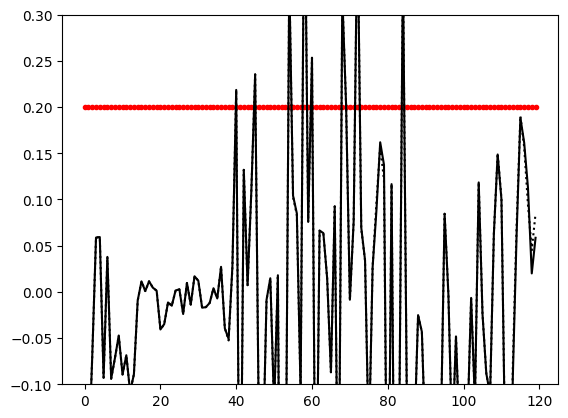

step: 163 0.043870514288284826
[[-1.7081383e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.1055040e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.8124072e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7590508e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.8977007e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0793607e-08]]
[ 0.21857682 -0.34863648  0.13207485  0.00726214  0.10992731  0.23538989
 -0.1573391  -0.18942554 -0.00873757  0.01473561 -0.12437986  0.01800483
 -0.6133736  -0.2721991   0.34073502  0.10388552  0.08490452 -0.10896467
  0.47462785  0.07570439  0.25335035 -0.31124076  0.06629799  0.06362442
  0.01474072 -0.08695647  0.0925468  -0.29546183  0.3199687   0.20219241
 -0.

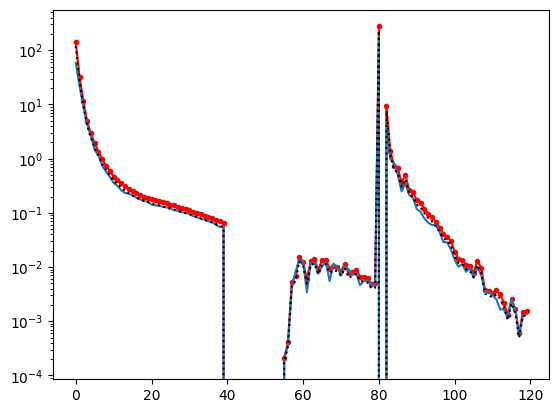

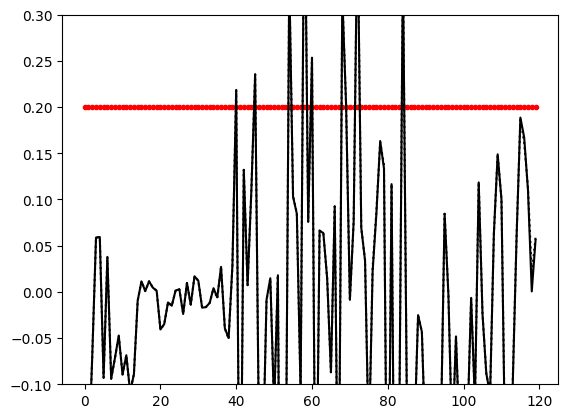

step: 166 0.04167698857387058
[[-2.38885009e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.01951396e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.40893564e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.08865715e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.08483634e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.49348516e-05]]
[ 0.21858896 -0.34782818  0.13229525  0.00194924  0.11130694  0.23725376
 -0.15719679 -0.1907633  -0.01906524  0.0101351  -0.12495229  0.02239623
 -0.6118573  -0.27145028  0.34673706  0.10203253  0.08158525 -0.11828098
  0.46761006  0.0723922   0.25203124 -0.3157336   0.06455539  0.06206607
  0.01298665 -0.09026298  0.09016864 -0.30

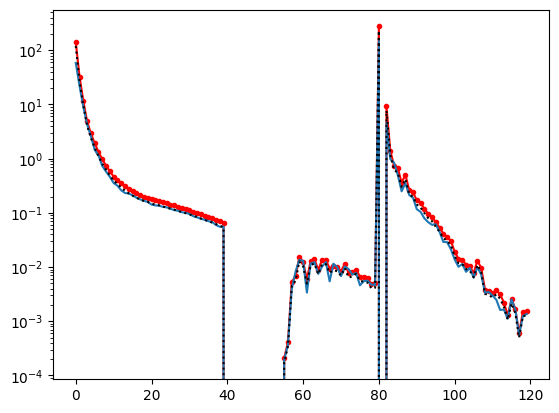

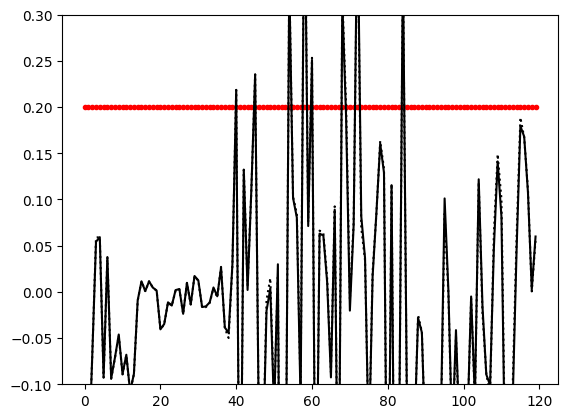

step: 169 0.03959313914517705
[[-1.2769696e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.7572218e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.9980360e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3227338e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.9856048e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8306382e-05]]
[ 0.21525115 -0.35040426  0.13081019 -0.00783944  0.1003094   0.22747386
 -0.16073307 -0.19073513 -0.02505374 -0.00345753 -0.13182847  0.03044831
 -0.6098183  -0.2706972   0.3420588   0.10124145  0.07993353 -0.121192
  0.46329787  0.07036618  0.25016102 -0.31575358  0.06205372  0.06008441
  0.00834149 -0.09242726  0.0900882  -0.30531517  0.3131106   0.18583609
 -0.022

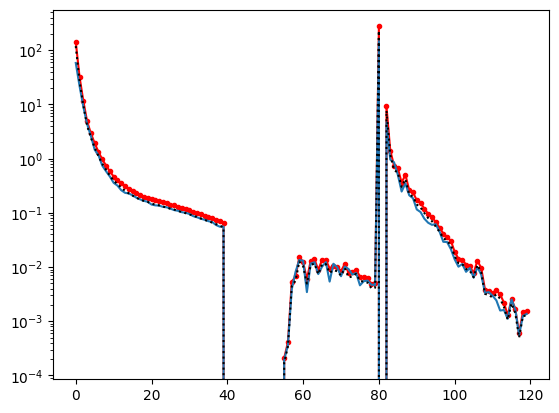

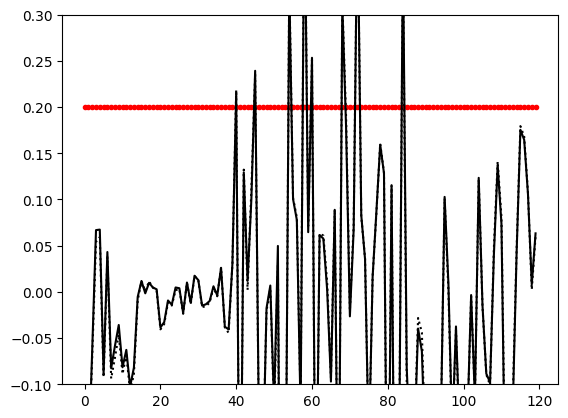

step: 172 0.0376134821879182
[[-4.9626579e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.7057203e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.1617089e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2087566e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.1366042e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9377594e-05]]
[ 0.22136949 -0.35586923  0.11883567  0.02141445  0.11054716  0.22761749
 -0.14496131 -0.19183783 -0.01460528 -0.00259615 -0.13085547  0.03984052
 -0.59831375 -0.26843846  0.3418585   0.1001667   0.07877384 -0.12797861
  0.45383343  0.06292118  0.25061485 -0.30416402  0.06025432  0.05666288
 -0.00222015 -0.09773622  0.09082863 -0.3108074   0.3112424   0.177064
 -0.0276

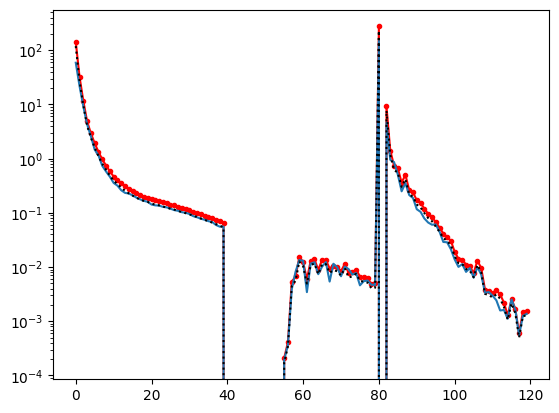

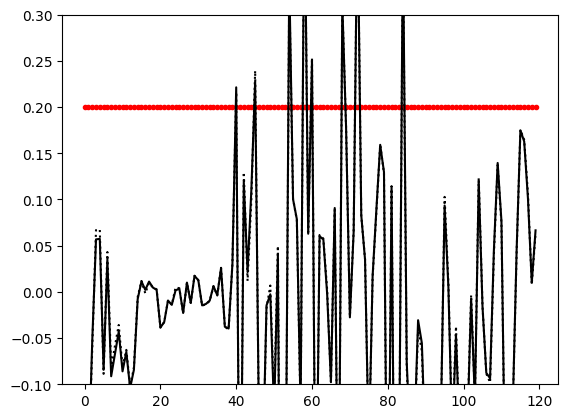

step: 175 0.035732808078522284
[[-8.3885736e-17  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.4255666e-16  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4457979e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3198105e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.2274586e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.2941779e-09]]
[ 0.22136949 -0.35586947  0.11883567  0.02141459  0.11054704  0.22761738
 -0.14496118 -0.19183756 -0.01460481 -0.00259641 -0.13085556  0.03983945
 -0.598308   -0.26842973  0.34186006  0.10021451  0.07874428 -0.12797642
  0.45381683  0.06292082  0.25060913 -0.30416662  0.06024869  0.05665758
 -0.00223065 -0.0977435   0.09079154 -0.310834    0.31123942  0.17708668
 -0.

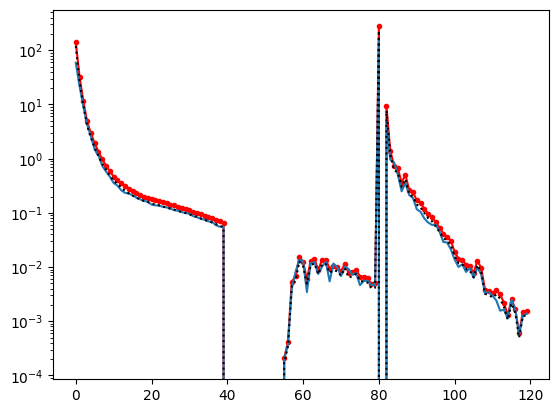

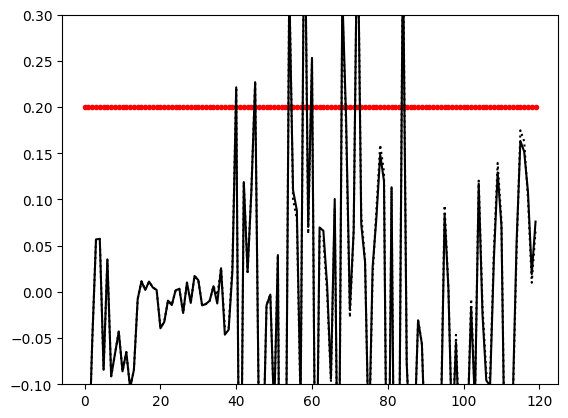

step: 178 0.03394616767459617
[[-2.6107036e-17  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.4192344e-16  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.0412208e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.2975968e-10
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.7254753e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.7879811e-08]]
[ 0.22136949 -0.3558698   0.11883947  0.02140536  0.1088049   0.22697279
 -0.1452979  -0.19192217 -0.01461987 -0.00292056 -0.13112167  0.03980574
 -0.59885544 -0.27496535  0.32987094  0.11009181  0.08836115 -0.12018601
  0.4546281   0.07049306  0.25326    -0.302353    0.06971983  0.06609804
  0.00668454 -0.09333768  0.10053547 -0.30467233  0.322954    0.18760958
 -0.0

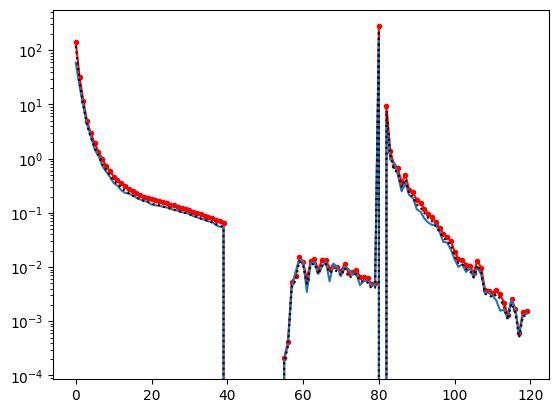

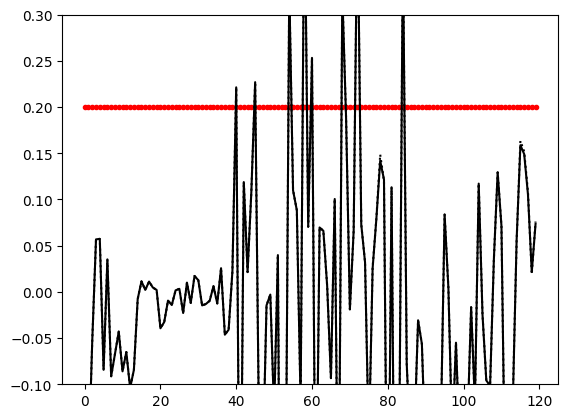

step: 181 0.03224885929086636
[[-1.5062548e-11  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2870364e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2370997e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.5399885e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1933552e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.7218839e-06]]
[ 0.22136949 -0.3558698   0.11883947  0.02140536  0.10880502  0.22697279
 -0.1452969  -0.191922   -0.01461957 -0.00292004 -0.13112102  0.03980653
 -0.5988542  -0.27496383  0.32987964  0.1097786   0.08823641 -0.12019397
  0.4546218   0.07049005  0.2532556  -0.3023604   0.06971616  0.06609403
  0.00667762 -0.09334496  0.10052445 -0.30468455  0.32293287  0.1875749
 -0.01

KeyboardInterrupt: 

In [27]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.7
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        # H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        epsilon = 1e-50  # A small value to avoid division by zero
        variance = np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0)
        variance += epsilon  # Add epsilon to the variance to prevent zero values
        H̃_inv_like_sims = np.diag(-1 / variance)
        print(H̃_inv_like_sims)
        
       # try:
        # H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-jnp.abs(ravel_θ(θ̃)*beta),jnp.abs(ravel_θ(θ̃)*beta))
        θ̃ = unravel_θ((ravel_θ(θ̃) - α * θ̃update))
        θ = θ̃
        print(((θ-tf_cut_flat)/tf_cut_flat)[40:])
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [ ]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [ ]:
#Now lets try to calculate the covariance! :D

In [ ]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [ ]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [ ]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

In [ ]:
Hs = []

In [ ]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [ ]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [28]:
Hs[0]

Array([[ 4.20410156e+00,  1.23046875e-01, -8.59878540e-01, ...,
        -1.51703596e-01, -2.16542006e-01,  1.04087591e-02],
       [ 2.88378906e+00,  2.01015625e+01,  1.14453125e+01, ...,
        -1.95632172e+00, -1.69345856e-01,  3.55811119e-02],
       [-1.85821533e-01,  3.92968750e+00,  1.37500000e+02, ...,
         9.35348511e-01,  4.57687378e-01,  1.10086769e-01],
       ...,
       [ 2.62776375e-01, -2.09358215e-01,  3.69171143e-01, ...,
         1.02032500e+04,  1.21103906e+03,  2.10466003e+00],
       [ 6.89918995e-02, -1.89603806e-01, -5.43937683e-02, ...,
         1.21110938e+03,  1.58834375e+03,  4.62094727e+01],
       [-7.46893883e-03, -1.12460852e-02,  2.46706232e-03, ...,
         2.66590881e+00,  4.72617188e+01,  1.86219482e+01]],      dtype=float32)

In [29]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)
try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

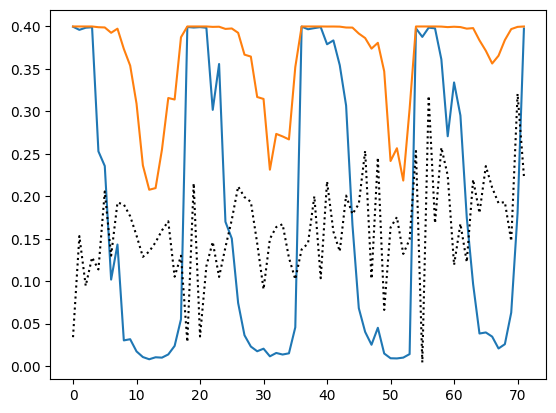

In [30]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

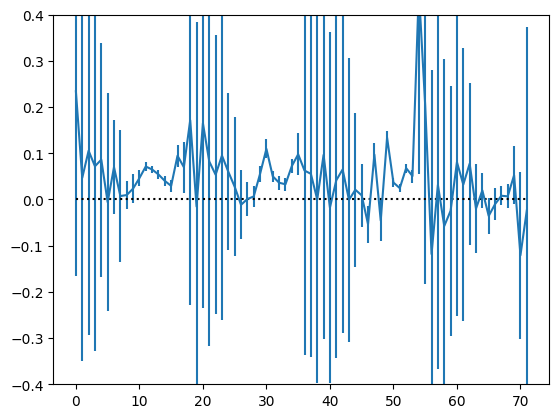

In [33]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

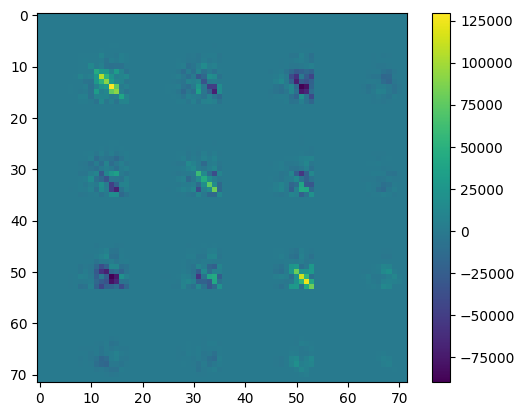

In [34]:
imshow(Σ_inv)
colorbar()